# **Study of Land Surface Temperature**
# **Clustering (k-Means) and Time Series Prediction (XGBoost)**

# 1. Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from itertools import combinations
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix, classification_report

# 2. Import Dataset

In [ ]:
df = pd.read_csv('data_average_surface_temperature.csv')
df

Entity Code  year         Day  Average surface temperature month  \
0       Afghanistan  AFG  1940  1940-01-15                          -2.032494   
1       Afghanistan  AFG  1940  1940-02-15                          -0.733503   
2       Afghanistan  AFG  1940  1940-03-15                           1.999134   
3       Afghanistan  AFG  1940  1940-04-15                          10.199754   
4       Afghanistan  AFG  1940  1940-05-15                          17.942135   
...             ...  ...   ...         ...                                ...   
198115     Zimbabwe  ZWE  2024  2024-04-15                          22.531397   
198116     Zimbabwe  ZWE  2024  2024-05-15                          19.965933   
198117     Zimbabwe  ZWE  2024  2024-06-15                          17.436783   
198118     Zimbabwe  ZWE  2024  2024-07-15                          18.830030   
198119     Zimbabwe  ZWE  2024  2024-08-15                          20.555496   

        Average surface temperature year  Temperature anomaly Continent  
0                              11.327695            -0.789005      Asia  
1                              11.327695            -1.594132      Asia  
2                              11.327695            -4.561447      Asia  
3                              11.327695            -2.868090      Asia  
4                              11.327695            -0.813093      Asia  
...                                  ...                  ...       ...  
198115                         21.787746             1.236568    Africa  
198116                         21.787746             1.077959    Africa  
198117                         21.787746             0.865648    Africa  
198118                         21.787746             2.686468    Africa  
198119                         21.787746             1.563381    Africa  

[198120 rows x 8 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198120 entries, 0 to 198119
Data columns (total 8 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Entity                             198120 non-null  object 
 1   Code                               198120 non-null  object 
 2   year                               198120 non-null  int64  
 3   Day                                198120 non-null  object 
 4   Average surface temperature month  198120 non-null  float64
 5   Average surface temperature year   198120 non-null  float64
 6   Temperature anomaly                198120 non-null  float64
 7   Continent                          198120 non-null  object 
dtypes: float64(3), int64(1), object(4)
memory usage: 12.1+ MB


# 3. Cleaning NaN value

In [ ]:
df.isnull().sum()

Entity                               0
Code                                 0
year                                 0
Day                                  0
Average surface temperature month    0
Average surface temperature year     0
Temperature anomaly                  0
Continent                            0
dtype: int64

# 4. Removing Outlier

In [ ]:
numeric_columns = ['Average surface temperature month',
                   'Average surface temperature year',
                   'Temperature anomaly']

Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outlier = df[~((df[numeric_columns] < lower_bound) | (df[numeric_columns] > upper_bound)).any(axis=1)]

print(f"Ukuran data sebelum menghapus outlier: {df.shape}")
print(f"Ukuran data setelah menghapus outlier: {df_no_outlier.shape}")

Ukuran data sebelum menghapus outlier: (198120, 8)
Ukuran data setelah menghapus outlier: (184282, 8)


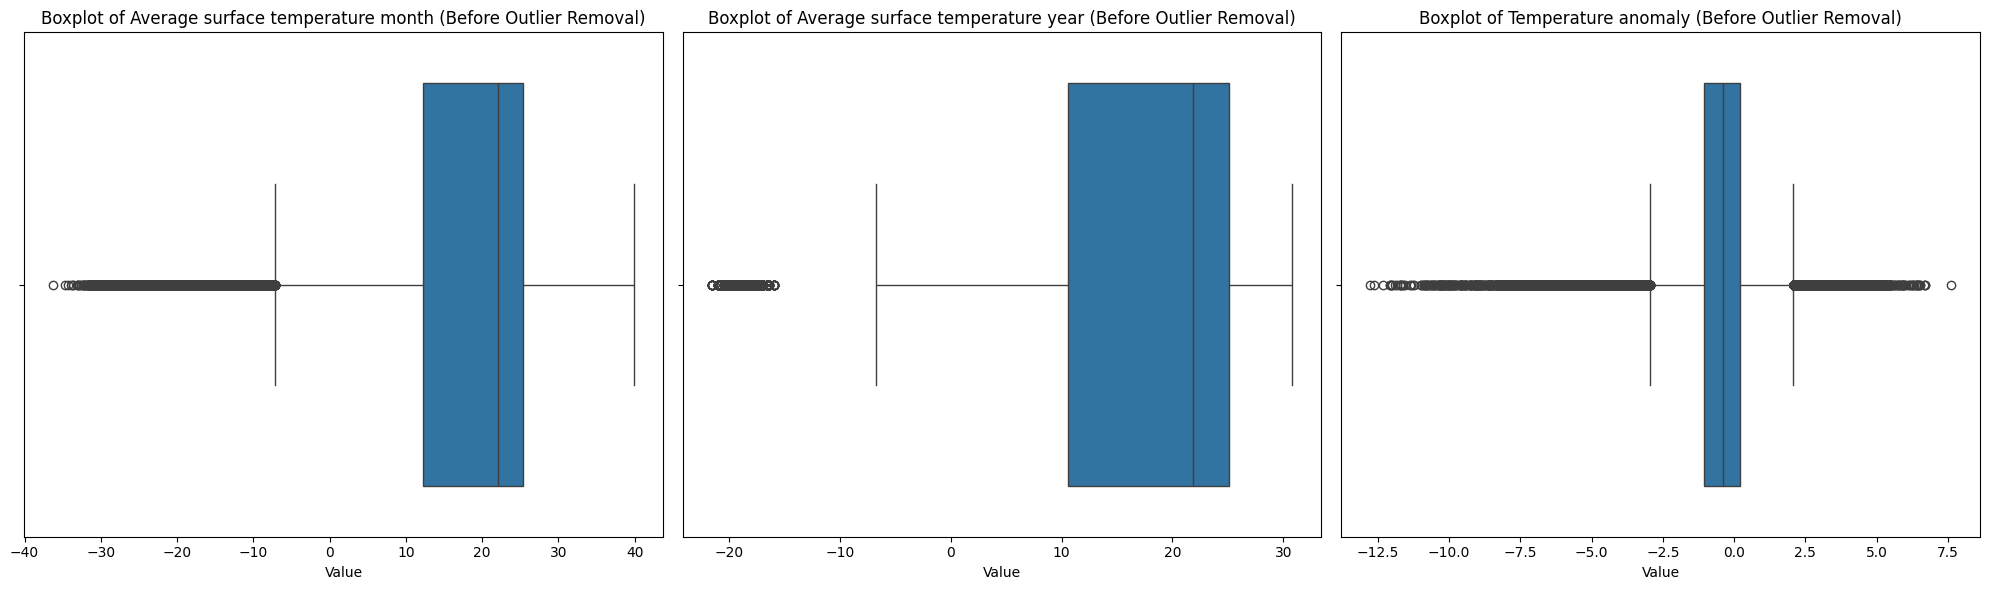

In [ ]:
plt.figure(figsize=(20, 6))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col} (Before Outlier Removal)')
    plt.xlabel('Value')

plt.tight_layout()
plt.show()

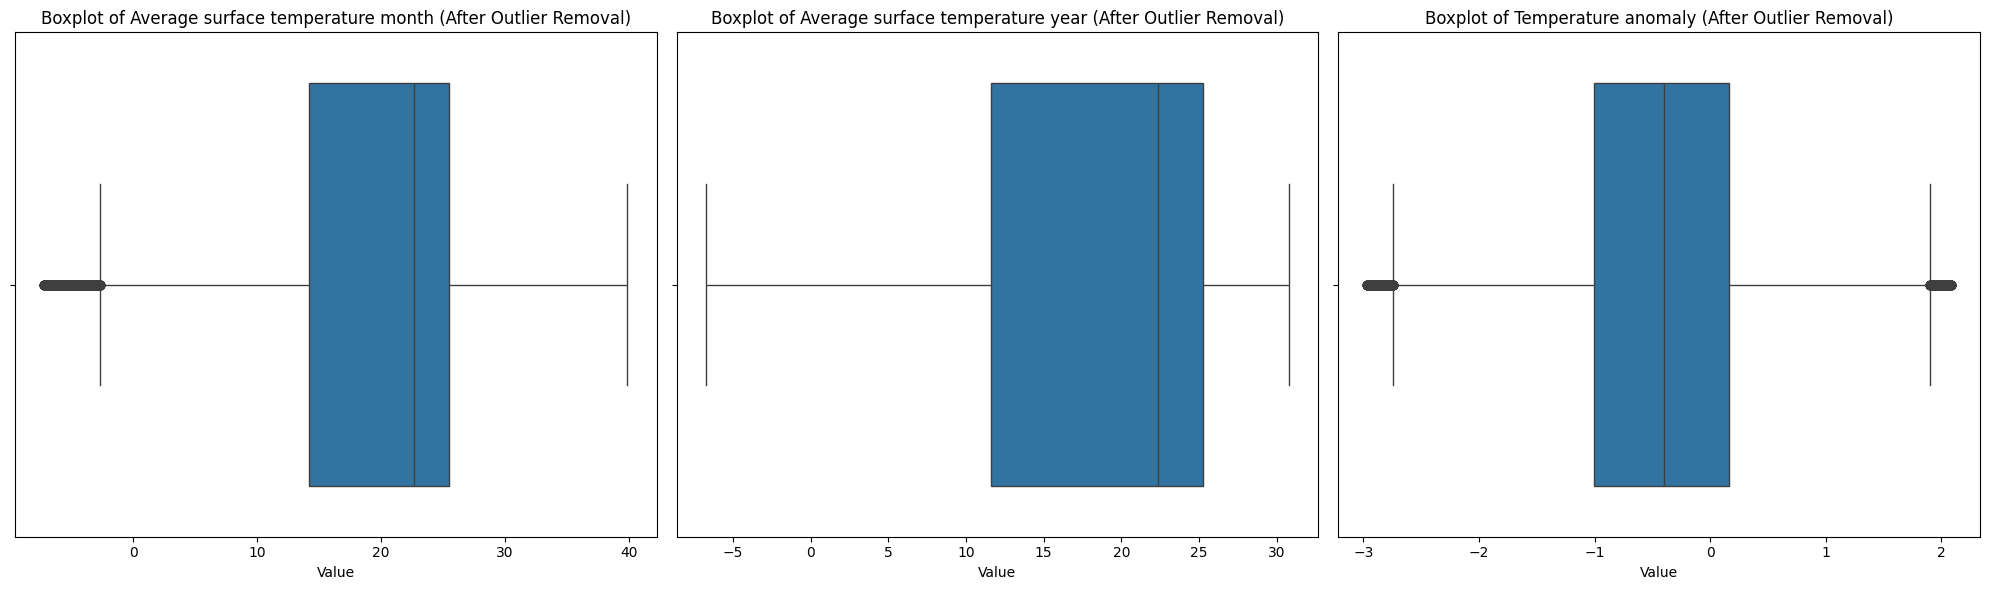

In [ ]:
plt.figure(figsize=(20, 6))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df_no_outlier[col])
    plt.title(f'Boxplot of {col} (After Outlier Removal)')
    plt.xlabel('Value')

plt.tight_layout()
plt.show()

# 5. Data Transformation

In [ ]:
df_no_outlier = df_no_outlier.rename(columns={'Average surface temperature month': 'Average_surface_temperature_month','Average surface temperature year': 'Average_surface_temperature_year','Temperature anomaly' : 'Temperature_anomaly'})

df_cleaned = df_no_outlier[df_no_outlier['Continent'] != 'Other']
df_cleaned['Day'] = pd.to_datetime(df_cleaned['Day'])

df_cleaned['month'] = pd.to_datetime(df_cleaned['Day']).dt.month

print(df_cleaned.info())
df_cleaned

<class 'pandas.core.frame.DataFrame'>
Index: 183266 entries, 0 to 198119
Data columns (total 9 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   Entity                             183266 non-null  object        
 1   Code                               183266 non-null  object        
 2   year                               183266 non-null  int64         
 3   Day                                183266 non-null  datetime64[ns]
 4   Average_surface_temperature_month  183266 non-null  float64       
 5   Average_surface_temperature_year   183266 non-null  float64       
 6   Temperature_anomaly                183266 non-null  float64       
 7   Continent                          183266 non-null  object        
 8   month                              183266 non-null  int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), object(3)
memory usage: 13.3+ MB
None


<ipython-input-8-b690afd59d00>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Day'] = pd.to_datetime(df_cleaned['Day'])
<ipython-input-8-b690afd59d00>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['month'] = pd.to_datetime(df_cleaned['Day']).dt.month


Entity Code  year        Day  Average_surface_temperature_month  \
0       Afghanistan  AFG  1940 1940-01-15                          -2.032494   
1       Afghanistan  AFG  1940 1940-02-15                          -0.733503   
3       Afghanistan  AFG  1940 1940-04-15                          10.199754   
4       Afghanistan  AFG  1940 1940-05-15                          17.942135   
5       Afghanistan  AFG  1940 1940-06-15                          23.203533   
...             ...  ...   ...        ...                                ...   
198112     Zimbabwe  ZWE  2024 2024-01-15                          23.768185   
198115     Zimbabwe  ZWE  2024 2024-04-15                          22.531397   
198116     Zimbabwe  ZWE  2024 2024-05-15                          19.965933   
198117     Zimbabwe  ZWE  2024 2024-06-15                          17.436783   
198119     Zimbabwe  ZWE  2024 2024-08-15                          20.555496   

        Average_surface_temperature_year  Temperature_anomaly Continent  month  
0                              11.327695            -0.789005      Asia      1  
1                              11.327695            -1.594132      Asia      2  
3                              11.327695            -2.868090      Asia      4  
4                              11.327695            -0.813093      Asia      5  
5                              11.327695             0.006361      Asia      6  
...                                  ...                  ...       ...    ...  
198112                         21.787746            -0.053595    Africa      1  
198115                         21.787746             1.236568    Africa      4  
198116                         21.787746             1.077959    Africa      5  
198117                         21.787746             0.865648    Africa      6  
198119                         21.787746             1.563381    Africa      8  

[183266 rows x 9 columns]

# 6. Data Normatization

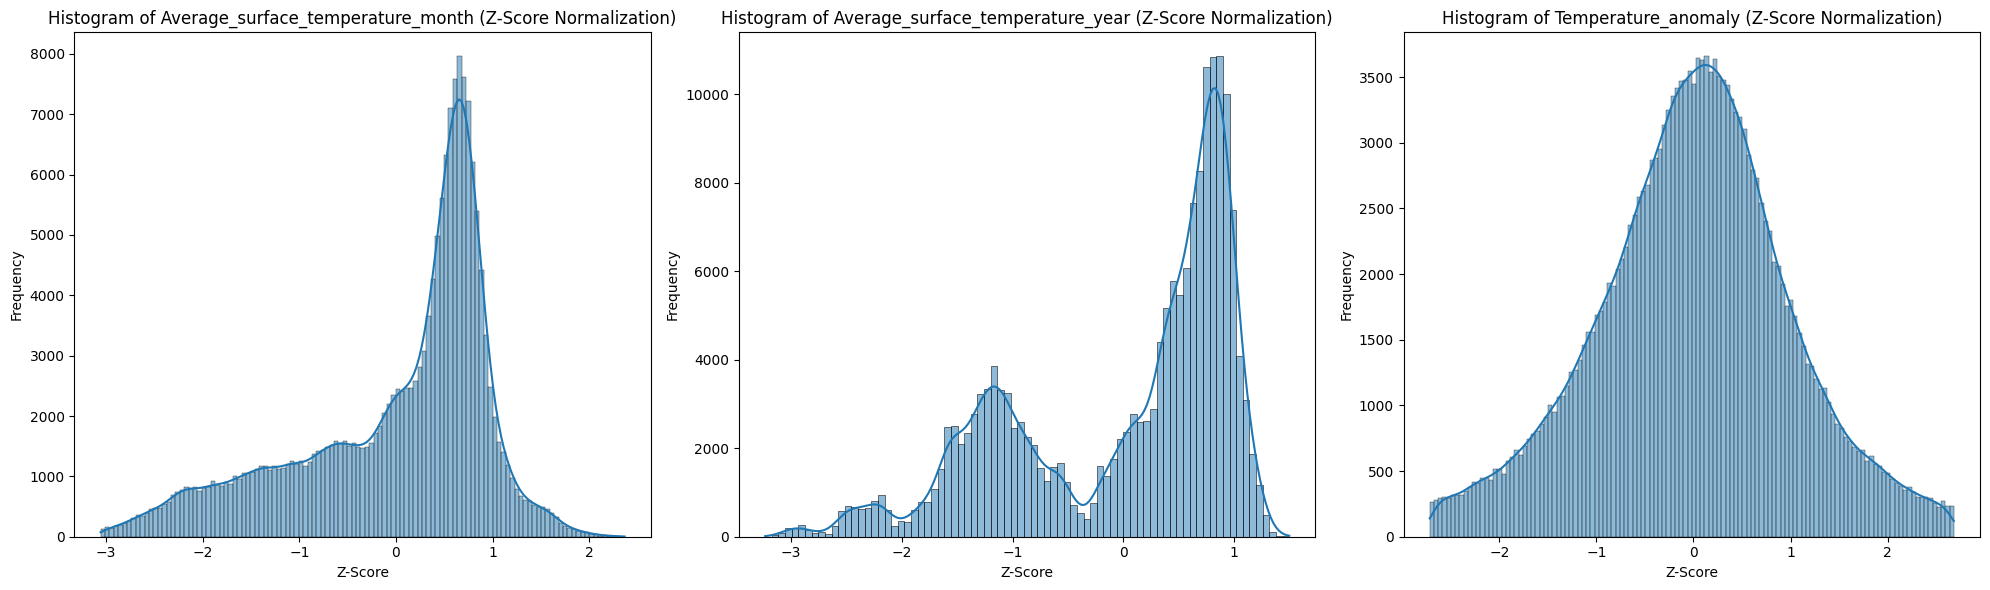

In [ ]:
df_iqr_zscore = df_no_outlier.copy()

numeric_columns = ['Average_surface_temperature_month',
                   'Average_surface_temperature_year',
                   'Temperature_anomaly']

for col in numeric_columns:
    df_iqr_zscore[col] = (df_no_outlier[col] - df_no_outlier[col].mean()) / df_no_outlier[col].std()

plt.figure(figsize=(20, 6))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_iqr_zscore[col], kde=True)
    plt.title(f'Histogram of {col} (Z-Score Normalization)')
    plt.xlabel('Z-Score')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 7. Binning

In [ ]:
df_label = df_cleaned.copy()

label_encoder = LabelEncoder()

df_label['Continent'] = label_encoder.fit_transform(df_label['Continent'])
df_label['Entity'] = label_encoder.fit_transform(df_label['Entity'])

df_label['Entity'] = df_label['Entity'].astype(float)
df_label['year'] = df_label['year'].astype(float)

df_label

Entity Code    year        Day  Average_surface_temperature_month  \
0          0.0  AFG  1940.0 1940-01-15                          -2.032494   
1          0.0  AFG  1940.0 1940-02-15                          -0.733503   
3          0.0  AFG  1940.0 1940-04-15                          10.199754   
4          0.0  AFG  1940.0 1940-05-15                          17.942135   
5          0.0  AFG  1940.0 1940-06-15                          23.203533   
...        ...  ...     ...        ...                                ...   
198112   192.0  ZWE  2024.0 2024-01-15                          23.768185   
198115   192.0  ZWE  2024.0 2024-04-15                          22.531397   
198116   192.0  ZWE  2024.0 2024-05-15                          19.965933   
198117   192.0  ZWE  2024.0 2024-06-15                          17.436783   
198119   192.0  ZWE  2024.0 2024-08-15                          20.555496   

        Average_surface_temperature_year  Temperature_anomaly  Continent  \
0                              11.327695            -0.789005          2   
1                              11.327695            -1.594132          2   
3                              11.327695            -2.868090          2   
4                              11.327695            -0.813093          2   
5                              11.327695             0.006361          2   
...                                  ...                  ...        ...   
198112                         21.787746            -0.053595          0   
198115                         21.787746             1.236568          0   
198116                         21.787746             1.077959          0   
198117                         21.787746             0.865648          0   
198119                         21.787746             1.563381          0   

        month  
0           1  
1           2  
3           4  
4           5  
5           6  
...       ...  
198112      1  
198115      4  
198116      5  
198117      6  
198119      8  

[183266 rows x 9 columns]

# 8. Predictor Variable Analysis

In [ ]:
df_cleaned.describe()

year                            Day  \
count  183266.000000                         183266   
mean     1981.909492  1982-05-30 00:33:29.302325568   
min      1940.000000            1940-01-15 00:00:00   
25%      1961.000000            1961-05-15 00:00:00   
50%      1982.000000            1982-06-15 00:00:00   
75%      2003.000000            2003-05-15 00:00:00   
max      2024.000000            2024-08-15 00:00:00   
std        24.294857                            NaN   

       Average_surface_temperature_month  Average_surface_temperature_year  \
count                      183266.000000                     183266.000000   
mean                           19.368769                         18.944002   
min                            -7.204618                         -6.767322   
25%                            14.256581                         11.580508   
50%                            22.701346                         22.417273   
75%                            25.470914                         25.271414   
max                            39.889374                         30.802809   
std                             8.695322                          7.955060   

       Temperature_anomaly          month  
count        183266.000000  183266.000000  
mean             -0.426438       6.549747  
min              -2.966005       1.000000  
25%              -1.006831       4.000000  
50%              -0.395741       7.000000  
75%               0.161550       9.000000  
max               2.081630      12.000000  
std               0.936827       3.387072

# 9. Target Variable Analysis

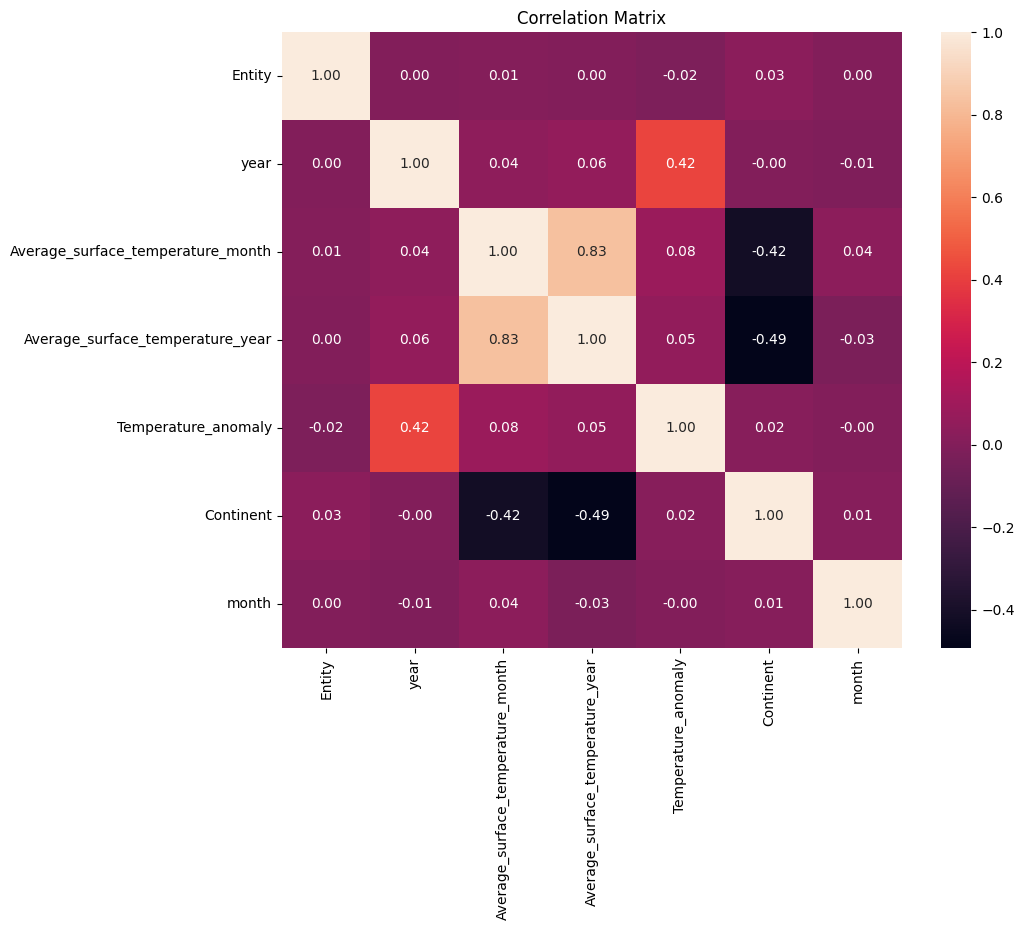

In [ ]:
columns_for_correlation = ['Entity', 'year', 'Average_surface_temperature_month', 'Average_surface_temperature_year', 'Temperature_anomaly', 'Continent', 'month']

correlation_matrix = df_label[columns_for_correlation].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# 10. Data Visualization

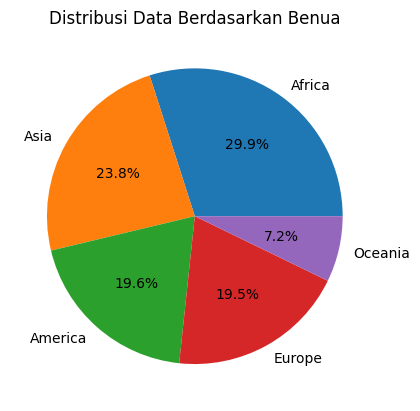

In [ ]:
data_per_benua = df_cleaned['Continent'].value_counts()
labels = data_per_benua.index

plt.pie(data_per_benua, labels=labels, autopct='%1.1f%%')
plt.title('Distribusi Data Berdasarkan Benua')
plt.show()

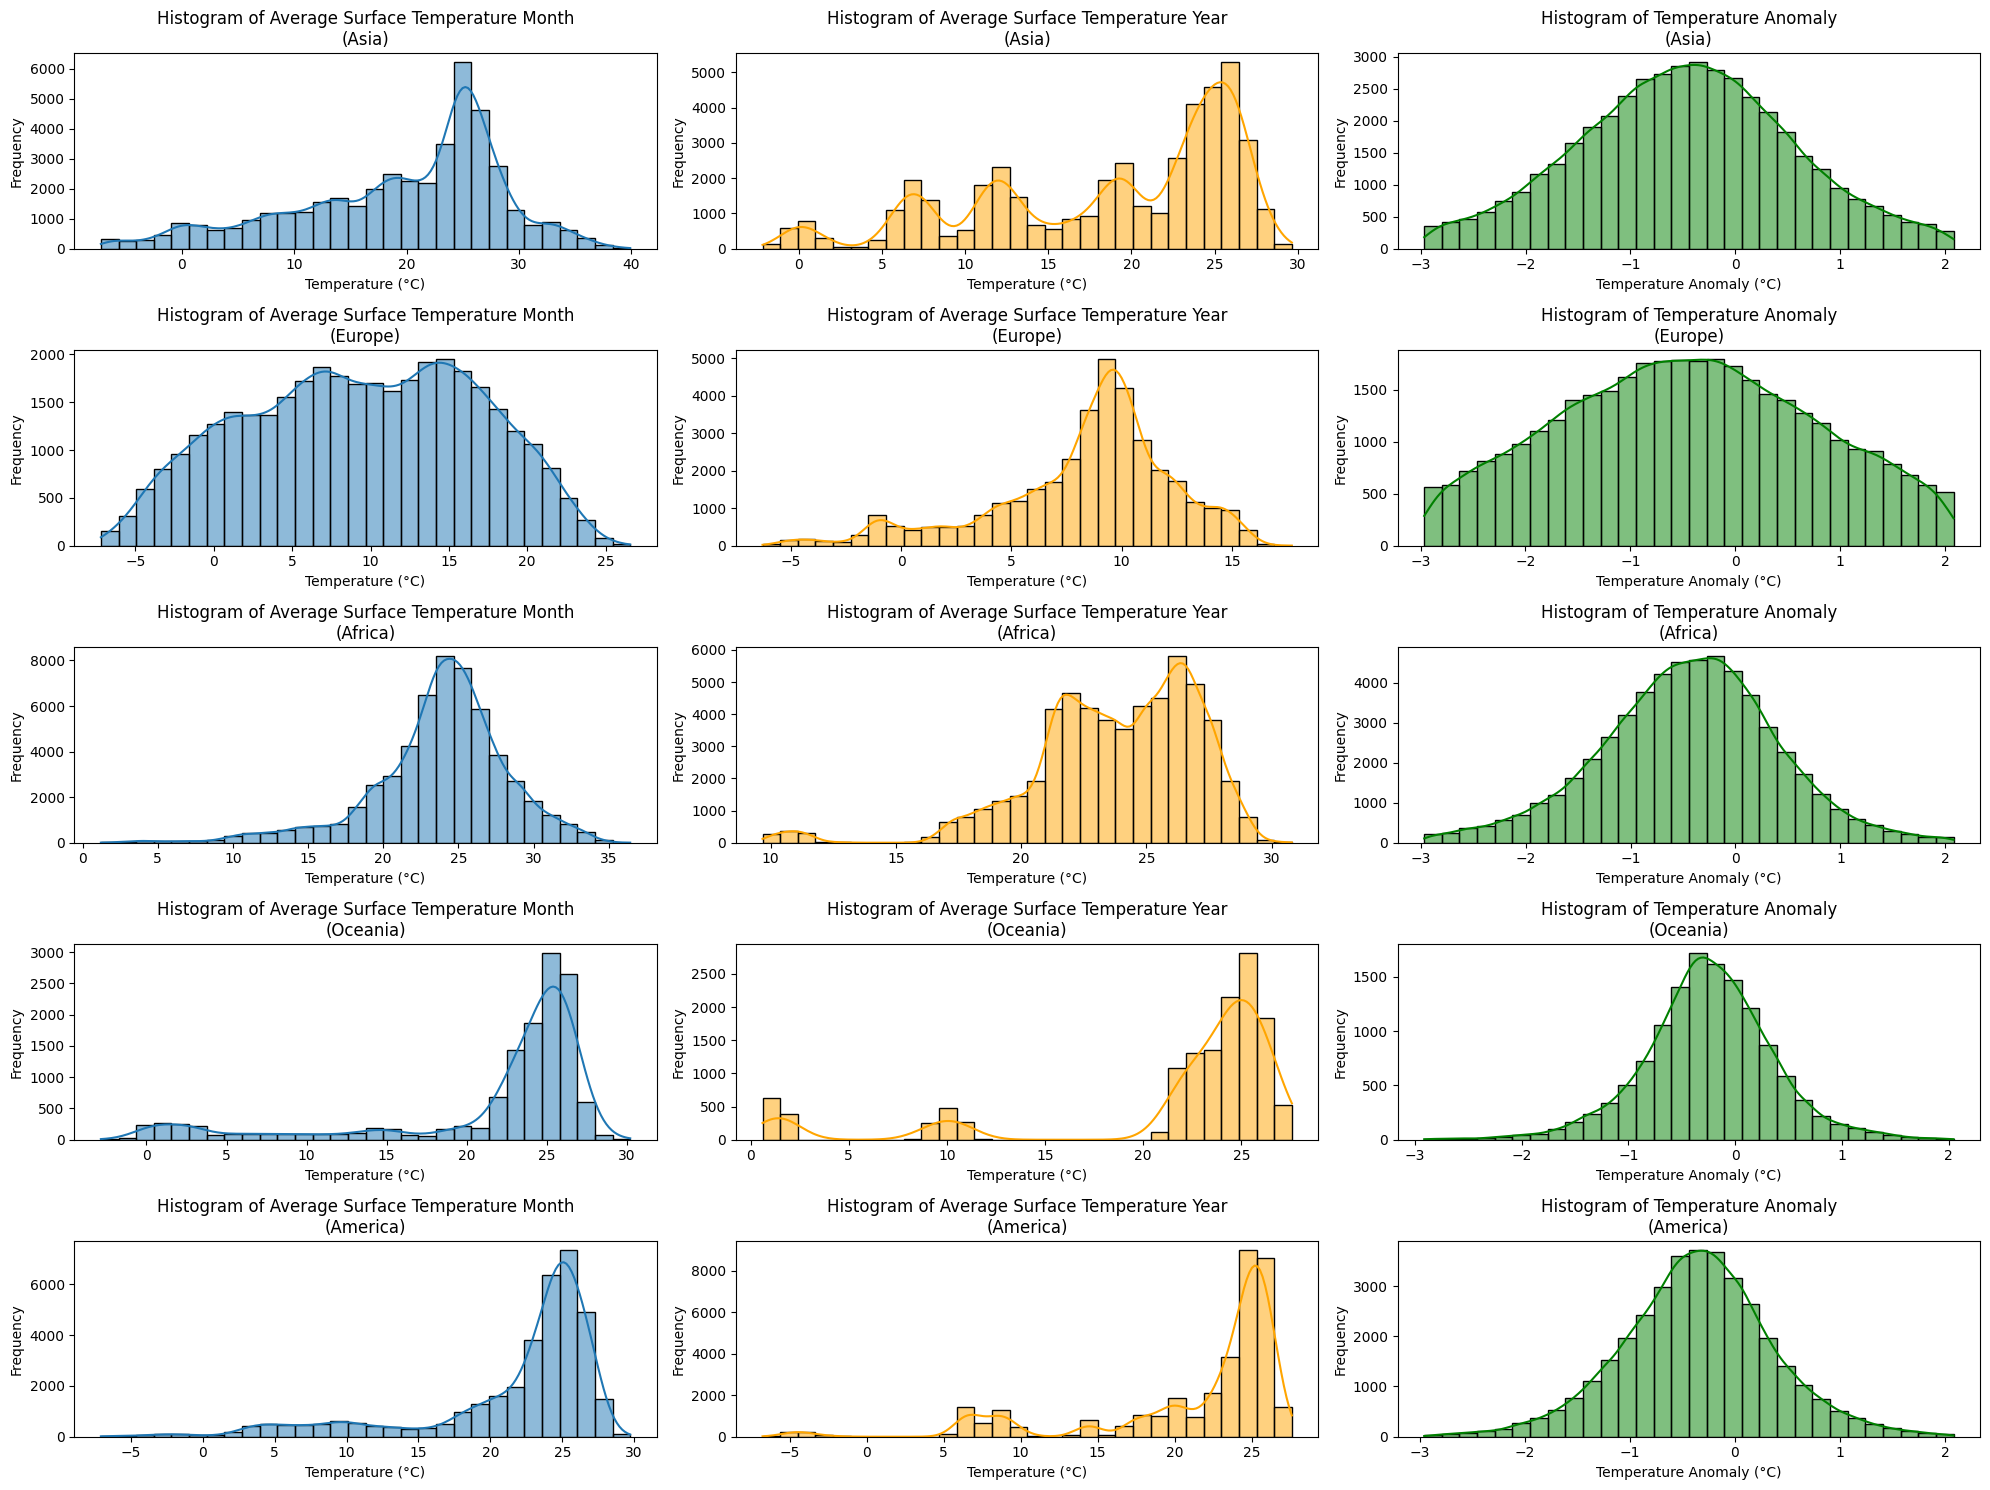

In [ ]:
plt.figure(figsize=(20, 15))

continents = df_cleaned['Continent'].unique()

for i, continent in enumerate(continents):
    continent_data = df_cleaned[df_cleaned['Continent'] == continent]

    plt.subplot(len(continents), 3, i * 3 + 1)
    sns.histplot(continent_data['Average_surface_temperature_month'], bins=30, kde=True)
    plt.title(f'Histogram of Average Surface Temperature Month\n({continent})')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')

    plt.subplot(len(continents), 3, i * 3 + 2)
    sns.histplot(continent_data['Average_surface_temperature_year'], bins=30, kde=True, color='orange')
    plt.title(f'Histogram of Average Surface Temperature Year\n({continent})')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')

    plt.subplot(len(continents), 3, i * 3 + 3)
    sns.histplot(continent_data['Temperature_anomaly'], bins=30, kde=True, color='green')
    plt.title(f'Histogram of Temperature Anomaly\n({continent})')
    plt.xlabel('Temperature Anomaly (°C)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

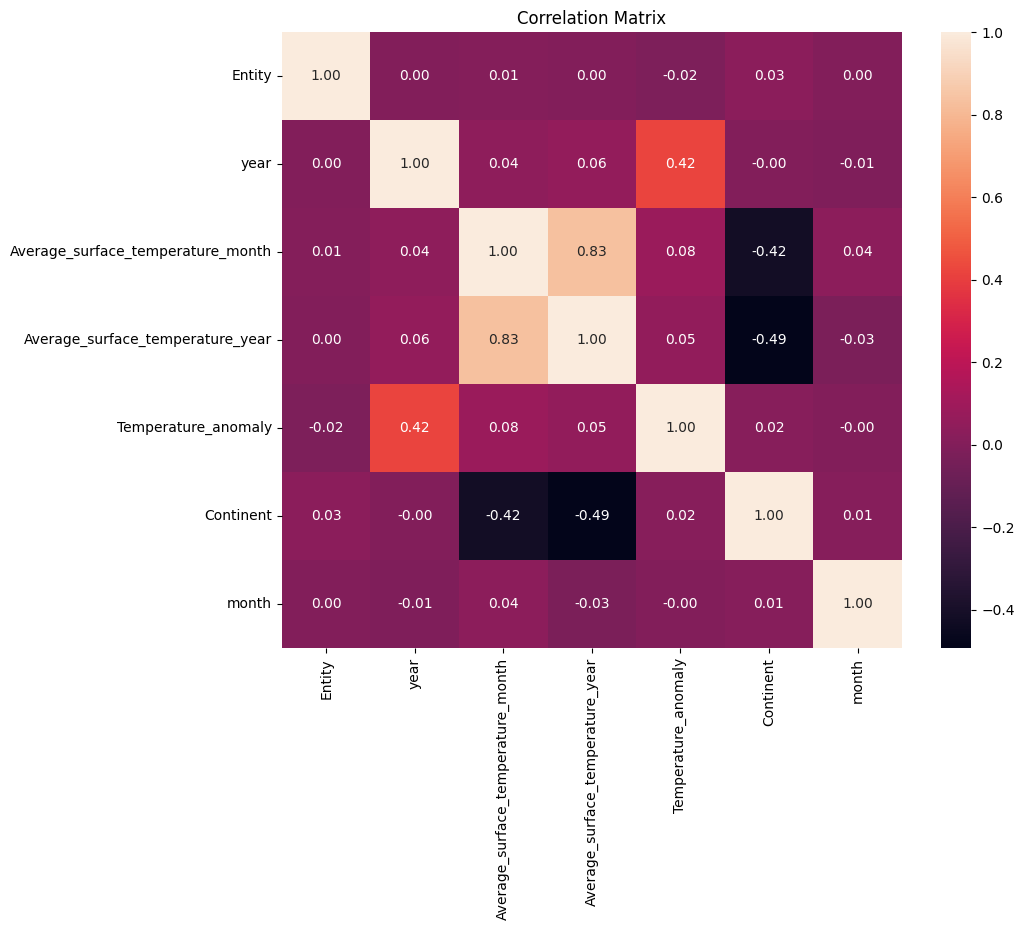

In [ ]:
columns_for_correlation = ['Entity', 'year', 'Average_surface_temperature_month', 'Average_surface_temperature_year', 'Temperature_anomaly', 'Continent', 'month']

correlation_matrix = df_label[columns_for_correlation].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# 11. Clustering (K-Means)

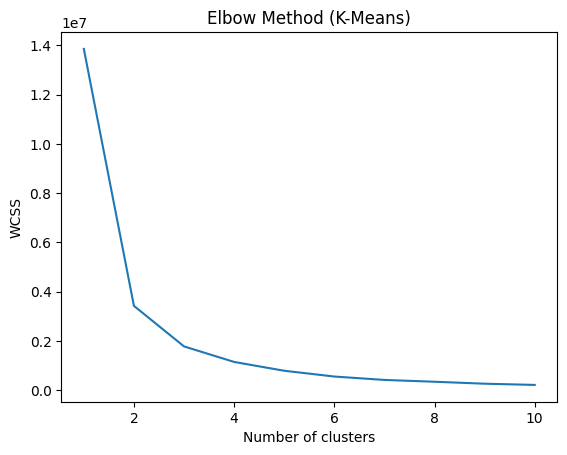

In [ ]:
df_cluster = df_cleaned.copy()

kmeans_data = df_cluster[['Average_surface_temperature_month']]

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(kmeans_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method (K-Means)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(kmeans_data)

df_cluster['kmeans_cluster'] = kmeans.labels_

fig = px.scatter(df_cluster, x='year', y='Average_surface_temperature_month', color='kmeans_cluster')
fig.update_layout(title_text='Clustering K-Means one world with Average Surface Temperature Month')
fig.show()

In [ ]:
silhouette_avg = silhouette_score(kmeans_data, df_cluster['kmeans_cluster'])
print(f"Silhouette Score for K-Means: {silhouette_avg}")

silhouette_vals = silhouette_samples(kmeans_data, df_cluster['kmeans_cluster'])

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[df_cluster['kmeans_cluster'] == i]
    cluster_silhouette_avg = np.mean(cluster_silhouette_vals)
    print(f"Silhouette score for cluster {i}: {cluster_silhouette_avg}")

Silhouette Score for K-Means: 0.6166198168076107
Silhouette score for cluster 0: 0.6756158013680301
Silhouette score for cluster 1: 0.581673328587972
Silhouette score for cluster 2: 0.49477698578774776


In [ ]:
for cluster_num in range(optimal_k):
    cluster_data = df_cluster[df_cluster['kmeans_cluster'] == cluster_num]
    print(f"\nDescriptive Statistics for Cluster {cluster_num}:")
    print(cluster_data['Average_surface_temperature_month'].describe())


Descriptive Statistics for Cluster 0:
count    109066.000000
mean         25.271085
std           2.720831
min          20.433900
25%          23.486350
50%          25.030836
75%          26.565920
max          39.889374
Name: Average_surface_temperature_month, dtype: float64

Descriptive Statistics for Cluster 1:
count    29993.000000
mean         3.370761
std          4.112891
min         -7.204618
25%          0.349094
50%          3.923803
75%          6.889761
max          9.470963
Name: Average_surface_temperature_month, dtype: float64

Descriptive Statistics for Cluster 2:
count    44207.000000
mean        15.660902
std          3.218929
min          9.471696
25%         12.978998
50%         15.987573
75%         18.595999
max         20.433481
Name: Average_surface_temperature_month, dtype: float64


In [ ]:
df_cluster['Temperature_Category'] = df_cluster['kmeans_cluster'].map({2: 'Moderate', 0: 'Hot', 1: 'Cold'})

df_cluster

Entity Code  year        Day  Average_surface_temperature_month  \
0       Afghanistan  AFG  1940 1940-01-15                          -2.032494   
1       Afghanistan  AFG  1940 1940-02-15                          -0.733503   
3       Afghanistan  AFG  1940 1940-04-15                          10.199754   
4       Afghanistan  AFG  1940 1940-05-15                          17.942135   
5       Afghanistan  AFG  1940 1940-06-15                          23.203533   
...             ...  ...   ...        ...                                ...   
198112     Zimbabwe  ZWE  2024 2024-01-15                          23.768185   
198115     Zimbabwe  ZWE  2024 2024-04-15                          22.531397   
198116     Zimbabwe  ZWE  2024 2024-05-15                          19.965933   
198117     Zimbabwe  ZWE  2024 2024-06-15                          17.436783   
198119     Zimbabwe  ZWE  2024 2024-08-15                          20.555496   

        Average_surface_temperature_year  Temperature_anomaly Continent  \
0                              11.327695            -0.789005      Asia   
1                              11.327695            -1.594132      Asia   
3                              11.327695            -2.868090      Asia   
4                              11.327695            -0.813093      Asia   
5                              11.327695             0.006361      Asia   
...                                  ...                  ...       ...   
198112                         21.787746            -0.053595    Africa   
198115                         21.787746             1.236568    Africa   
198116                         21.787746             1.077959    Africa   
198117                         21.787746             0.865648    Africa   
198119                         21.787746             1.563381    Africa   

        month  kmeans_cluster Temperature_Category  
0           1               1                 Cold  
1           2               1                 Cold  
3           4               2             Moderate  
4           5               2             Moderate  
5           6               0                  Hot  
...       ...             ...                  ...  
198112      1               0                  Hot  
198115      4               0                  Hot  
198116      5               2             Moderate  
198117      6               2             Moderate  
198119      8               0                  Hot  

[183266 rows x 11 columns]

In [ ]:
temperature_count_by_country = df_cluster.groupby(['Entity','Continent', 'Temperature_Category'])['Temperature_Category'].count().unstack(fill_value=0)

temperature_count_by_country['Temperature_Category'] = temperature_count_by_country[['Cold', 'Hot', 'Moderate']].idxmax(axis=1)

temperature_count_by_country

Temperature_Category      Cold   Hot  Moderate Temperature_Category
Entity         Continent                                           
Afghanistan    Asia        341   261       291                 Cold
Albania        Europe      342   150       427             Moderate
Algeria        Africa        6   566       376                  Hot
American Samoa Oceania       0  1016         0                  Hot
Andorra        Europe      560     0       300                 Cold
...                        ...   ...       ...                  ...
Venezuela      America       0  1013         0                  Hot
Vietnam        Asia          0   814       192                  Hot
Yemen          Asia          0   784       200                  Hot
Zambia         Africa        0   748       265                  Hot
Zimbabwe       Africa        0   643       355                  Hot

[193 rows x 4 columns]

In [ ]:
temperature_count_by_country = temperature_count_by_country.reset_index()

continent_category_counts = temperature_count_by_country.groupby(['Continent', 'Temperature_Category'])['Entity'].nunique().reset_index()

continent_category_counts = continent_category_counts.rename(columns={'Entity': 'Country_Count'})

continent_category_counts

Continent Temperature_Category  Country_Count
0     Africa                  Hot             48
1     Africa             Moderate              7
2    America                 Cold              5
3    America                  Hot             26
4    America             Moderate              5
5       Asia                 Cold             13
6       Asia                  Hot             30
7       Asia             Moderate              4
8     Europe                 Cold             20
9     Europe             Moderate             22
10   Oceania                 Cold              1
11   Oceania                  Hot             11
12   Oceania             Moderate              1

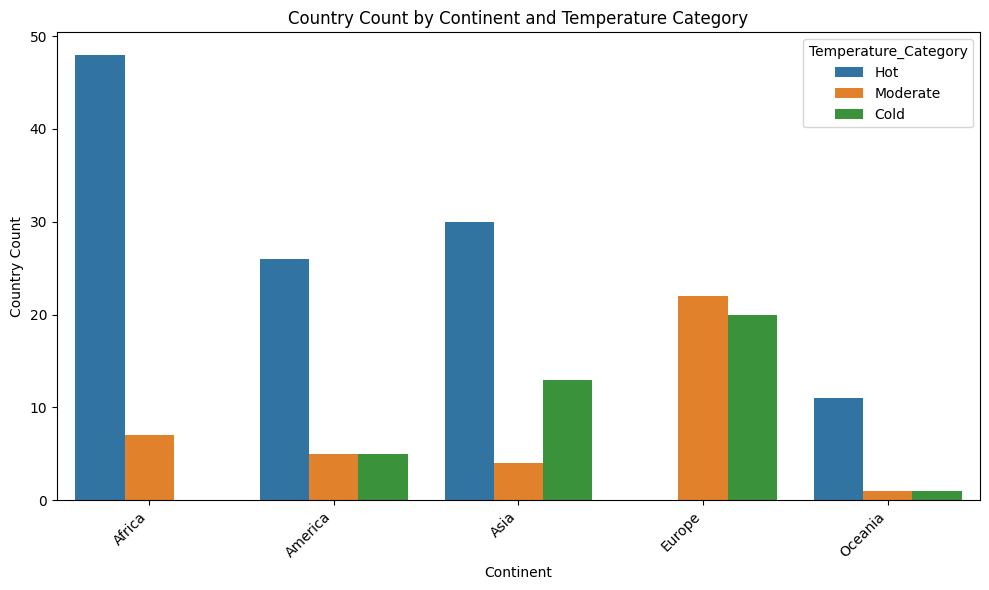

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Continent', y='Country_Count', hue='Temperature_Category', data=continent_category_counts)
plt.title('Country Count by Continent and Temperature Category')
plt.xlabel('Continent')
plt.ylabel('Country Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
kmeans.fit(kmeans_data)

df_cluster['kmeans_cluster'] = kmeans.labels_

fig = px.scatter(df_cluster, x='year', y='Average_surface_temperature_month', color='kmeans_cluster')
fig.update_layout(title_text='Clustering K-Means one world with Average Surface Temperature Month')
fig.show()

In [ ]:
silhouette_avg = silhouette_score(kmeans_data, df_cluster['kmeans_cluster'])
print(f"Silhouette Score for K-Means: {silhouette_avg}")

silhouette_vals = silhouette_samples(kmeans_data, df_cluster['kmeans_cluster'])

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[df_cluster['kmeans_cluster'] == i]
    cluster_silhouette_avg = np.mean(cluster_silhouette_vals)
    print(f"Silhouette score for cluster {i}: {cluster_silhouette_avg}")

Silhouette Score for K-Means: 0.6919327953755235
Silhouette score for cluster 0: 0.7360811385751218
Silhouette score for cluster 1: 0.5765855884880388


In [ ]:
for cluster_num in range(optimal_k):
    cluster_data = df_cluster[df_cluster['kmeans_cluster'] == cluster_num]
    print(f"\nDescriptive Statistics for Cluster {cluster_num}:")
    print(cluster_data['Average_surface_temperature_month'].describe())


Descriptive Statistics for Cluster 0:
count    132538.000000
mean         24.037326
std           3.673625
min          15.606630
25%          21.871150
50%          24.427598
75%          26.174376
max          39.889374
Name: Average_surface_temperature_month, dtype: float64

Descriptive Statistics for Cluster 1:
count    50728.000000
mean         7.171144
std          5.671399
min         -7.204618
25%          2.871704
50%          7.855547
75%         12.085654
max         15.604295
Name: Average_surface_temperature_month, dtype: float64


In [ ]:
df_cluster['Temperature_Category'] = df_cluster['kmeans_cluster'].map({0: 'Hot', 1: 'Cold'})

df_cluster

Entity Code  year        Day  Average_surface_temperature_month  \
0       Afghanistan  AFG  1940 1940-01-15                          -2.032494   
1       Afghanistan  AFG  1940 1940-02-15                          -0.733503   
3       Afghanistan  AFG  1940 1940-04-15                          10.199754   
4       Afghanistan  AFG  1940 1940-05-15                          17.942135   
5       Afghanistan  AFG  1940 1940-06-15                          23.203533   
...             ...  ...   ...        ...                                ...   
198112     Zimbabwe  ZWE  2024 2024-01-15                          23.768185   
198115     Zimbabwe  ZWE  2024 2024-04-15                          22.531397   
198116     Zimbabwe  ZWE  2024 2024-05-15                          19.965933   
198117     Zimbabwe  ZWE  2024 2024-06-15                          17.436783   
198119     Zimbabwe  ZWE  2024 2024-08-15                          20.555496   

        Average_surface_temperature_year  Temperature_anomaly Continent  \
0                              11.327695            -0.789005      Asia   
1                              11.327695            -1.594132      Asia   
3                              11.327695            -2.868090      Asia   
4                              11.327695            -0.813093      Asia   
5                              11.327695             0.006361      Asia   
...                                  ...                  ...       ...   
198112                         21.787746            -0.053595    Africa   
198115                         21.787746             1.236568    Africa   
198116                         21.787746             1.077959    Africa   
198117                         21.787746             0.865648    Africa   
198119                         21.787746             1.563381    Africa   

        month  kmeans_cluster Temperature_Category  
0           1               1                 Cold  
1           2               1                 Cold  
3           4               1                 Cold  
4           5               0                  Hot  
5           6               0                  Hot  
...       ...             ...                  ...  
198112      1               0                  Hot  
198115      4               0                  Hot  
198116      5               0                  Hot  
198117      6               0                  Hot  
198119      8               0                  Hot  

[183266 rows x 11 columns]

In [ ]:
temperature_count_by_country = df_cluster.groupby(['Entity','Continent', 'Temperature_Category'])['Temperature_Category'].count().unstack(fill_value=0)

temperature_count_by_country['Temperature_Category'] = temperature_count_by_country[['Hot', 'Cold']].idxmax(axis=1)

temperature_count_by_country

Temperature_Category      Cold   Hot Temperature_Category
Entity         Continent                                 
Afghanistan    Asia        488   405                 Cold
Albania        Europe      564   355                 Cold
Algeria        Africa      226   722                  Hot
American Samoa Oceania       0  1016                  Hot
Andorra        Europe      840    20                 Cold
...                        ...   ...                  ...
Venezuela      America       0  1013                  Hot
Vietnam        Asia          0  1006                  Hot
Yemen          Asia          0   984                  Hot
Zambia         Africa        0  1013                  Hot
Zimbabwe       Africa       48   950                  Hot

[193 rows x 3 columns]

In [ ]:
temperature_count_by_country = temperature_count_by_country.reset_index()

continent_category_counts = temperature_count_by_country.groupby(['Continent', 'Temperature_Category'])['Entity'].nunique().reset_index()

continent_category_counts = continent_category_counts.rename(columns={'Entity': 'Country_Count'})

continent_category_counts

Continent Temperature_Category  Country_Count
0    Africa                 Cold              1
1    Africa                  Hot             54
2   America                 Cold              6
3   America                  Hot             30
4      Asia                 Cold             14
5      Asia                  Hot             33
6    Europe                 Cold             42
7   Oceania                 Cold              2
8   Oceania                  Hot             11

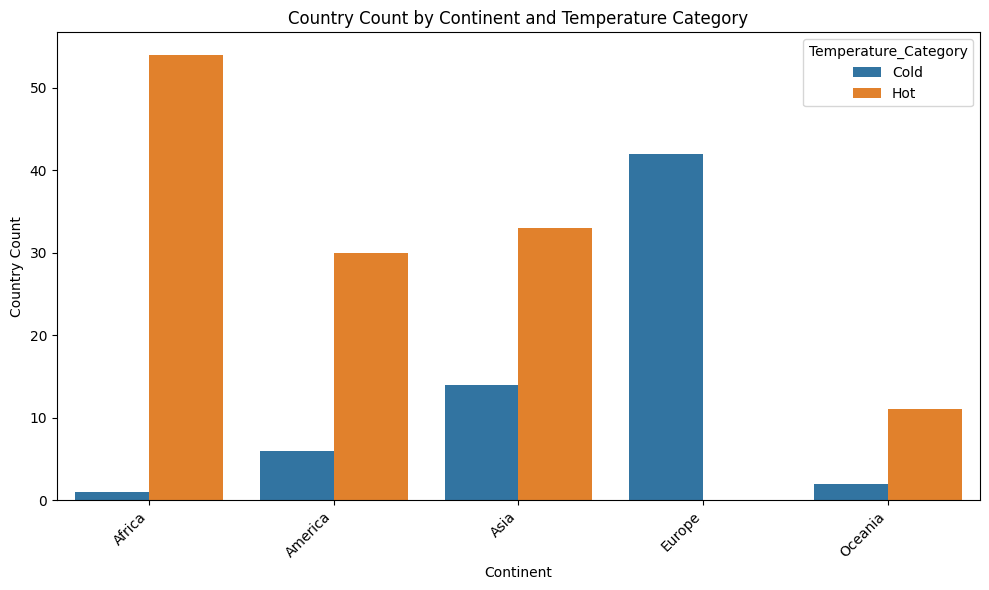

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Continent', y='Country_Count', hue='Temperature_Category', data=continent_category_counts)
plt.title('Country Count by Continent and Temperature Category')
plt.xlabel('Continent')
plt.ylabel('Country Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 12. Time Series (XGBoost)

# Indoensia

In [ ]:
df_ts = df_cleaned[df_cleaned['Entity'] == 'Indonesia']
print(df_ts.info())
df_ts.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 86360 to 87375
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Entity                             1016 non-null   object        
 1   Code                               1016 non-null   object        
 2   year                               1016 non-null   int64         
 3   Day                                1016 non-null   datetime64[ns]
 4   Average_surface_temperature_month  1016 non-null   float64       
 5   Average_surface_temperature_year   1016 non-null   float64       
 6   Temperature_anomaly                1016 non-null   float64       
 7   Continent                          1016 non-null   object        
 8   month                              1016 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), object(3)
memory usage: 75.4+ KB
None


Entity Code  year        Day  Average_surface_temperature_month  \
86360  Indonesia  IDN  1940 1940-01-15                          23.238176   
86361  Indonesia  IDN  1940 1940-02-15                          23.523900   
86362  Indonesia  IDN  1940 1940-03-15                          24.078897   
86363  Indonesia  IDN  1940 1940-04-15                          23.964584   
86364  Indonesia  IDN  1940 1940-05-15                          24.010174   

       Average_surface_temperature_year  Temperature_anomaly Continent  month  
86360                         24.057741            -1.757288      Asia      1  
86361                         24.057741            -1.577082      Asia      2  
86362                         24.057741            -1.145227      Asia      3  
86363                         24.057741            -1.397793      Asia      4  
86364                         24.057741            -1.453859      Asia      5

In [ ]:
X = df_ts[['year', 'month']]
y = df_ts['Average_surface_temperature_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = XGBRegressor()

model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose = 10)

[0]	validation_0-rmse:0.47650	validation_1-rmse:0.51069
[10]	validation_0-rmse:0.14889	validation_1-rmse:0.23248
[20]	validation_0-rmse:0.11722	validation_1-rmse:0.21297
[30]	validation_0-rmse:0.09914	validation_1-rmse:0.20097
[40]	validation_0-rmse:0.08638	validation_1-rmse:0.19487
[50]	validation_0-rmse:0.07904	validation_1-rmse:0.19278
[60]	validation_0-rmse:0.07101	validation_1-rmse:0.19024
[70]	validation_0-rmse:0.06574	validation_1-rmse:0.18991
[80]	validation_0-rmse:0.05861	validation_1-rmse:0.18927
[90]	validation_0-rmse:0.05242	validation_1-rmse:0.18977
[99]	validation_0-rmse:0.04837	validation_1-rmse:0.18910


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Absolute Error (MAE): 0.15119667724788893
Mean Squared Error (MSE): 0.03575784209914103
Root Mean Squared Error (RMSE): 0.18909744075248883
Mean Absolute Percentage Error (MAPE): 0.006127080759553714


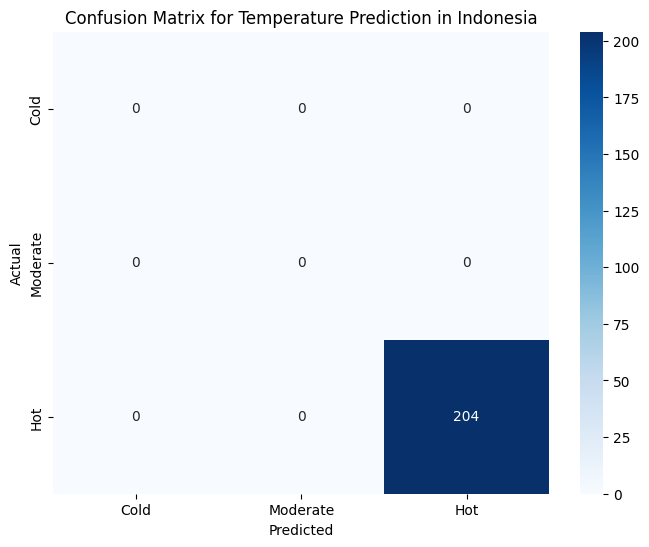

              precision    recall  f1-score   support

         Hot       1.00      1.00      1.00       204

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



In [ ]:
cold_threshold = 5.134167
hot_threshold = 18.507019

y_test_categories = []
for temp in y_test:
  if temp < cold_threshold:
    y_test_categories.append('Cold')
  elif temp < hot_threshold:
    y_test_categories.append('Moderate')
  else:
    y_test_categories.append('Hot')

y_pred_categories = []
for temp in y_pred:
  if temp < cold_threshold:
    y_pred_categories.append('Cold')
  elif temp < hot_threshold:
    y_pred_categories.append('Moderate')
  else:
    y_pred_categories.append('Hot')


cm = confusion_matrix(y_test_categories, y_pred_categories, labels=['Cold', 'Moderate', 'Hot'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=['Cold', 'Moderate', 'Hot'],yticklabels=['Cold', 'Moderate', 'Hot'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Temperature Prediction in Indonesia')
plt.show()

print(classification_report(y_test_categories, y_pred_categories))

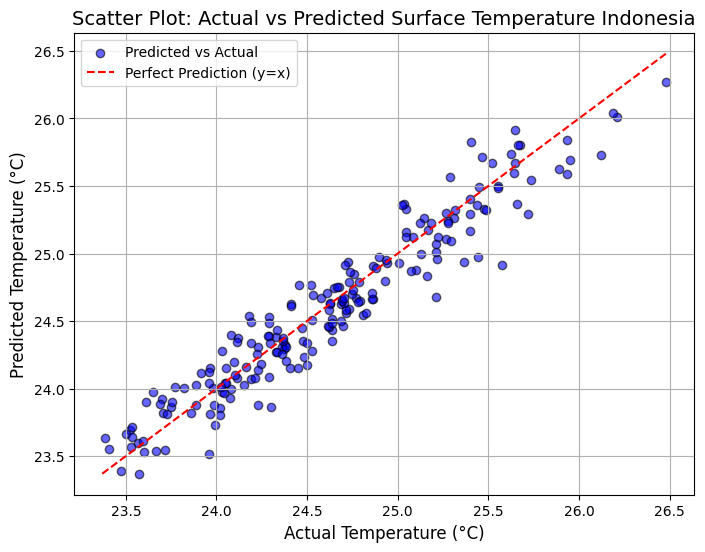

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolor='k', label='Predicted vs Actual')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction (y=x)')

plt.title('Scatter Plot: Actual vs Predicted Surface Temperature Indonesia', fontsize=14)
plt.xlabel('Actual Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

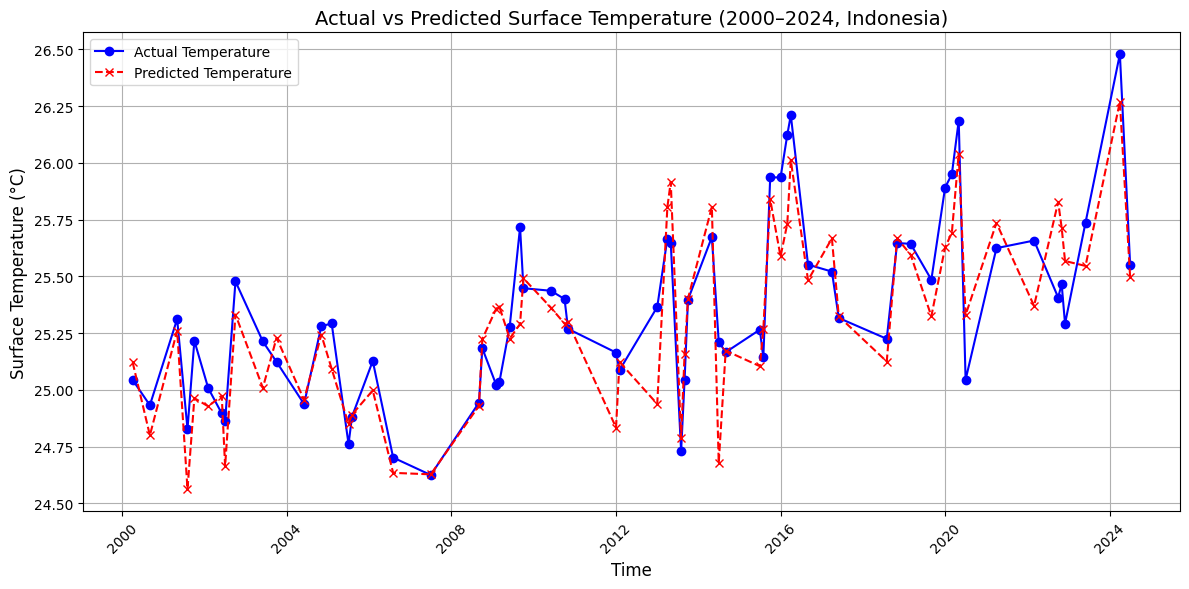

In [ ]:
data_visual_time = pd.DataFrame({
    'Year': X_test['year'],
    'Month': X_test['month'],
    'Actual Temperature': y_test.values,
    'Predicted Temperature': y_pred
})

data_visual_time['Time'] = pd.to_datetime(data_visual_time[['Year', 'Month']].assign(Day=1))
data_visual_time = data_visual_time.sort_values(by='Time')
data_visual_time_filtered = data_visual_time[(data_visual_time['Year'] >= 2000) & (data_visual_time['Year'] <= 2024)]

plt.figure(figsize=(12, 6))
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Actual Temperature'],label='Actual Temperature', color='blue', marker='o')
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Predicted Temperature'],label='Predicted Temperature', color='red', linestyle='--', marker='x')

plt.title('Actual vs Predicted Surface Temperature (2000–2024, Indonesia)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Surface Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

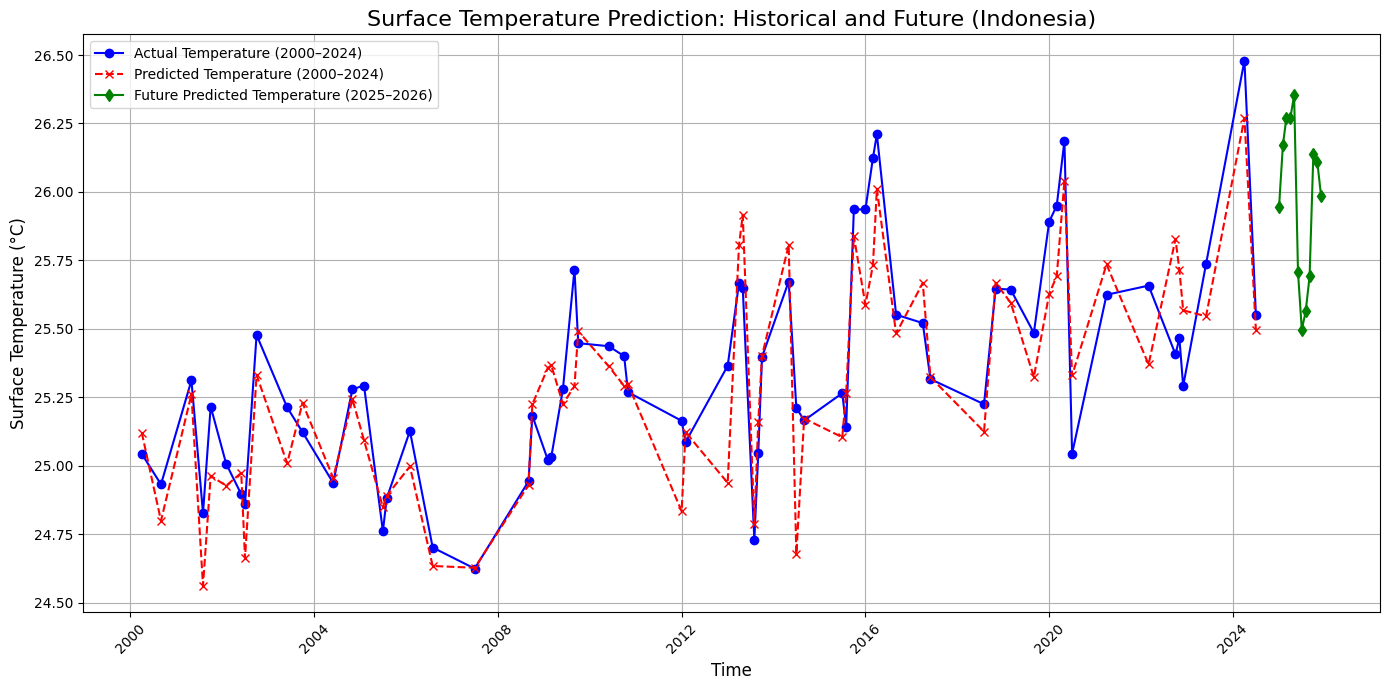

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(df_ts['Entity'])

future_years = pd.DataFrame({
    'year': np.repeat(range(2025, 2026), 12),
    'month': list(range(1, 13)),
    'average temperature year': [df_ts['Average_surface_temperature_year'].mean()] * 12,
    'Entity': [label_encoder.transform(['Indonesia'])[0]] * 12
})

future_years_for_prediction = future_years[['year', 'month']]
future_years['Predicted Temperature'] = model.predict(future_years_for_prediction)
future_years['Time'] = pd.to_datetime(future_years[['year', 'month']].assign(Day=1))

plt.figure(figsize=(14, 7))
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Actual Temperature'],label='Actual Temperature (2000–2024)', color='blue', marker='o')
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Predicted Temperature'],label='Predicted Temperature (2000–2024)', color='red', linestyle='--', marker='x')
plt.plot(future_years['Time'], future_years['Predicted Temperature'],label='Future Predicted Temperature (2025–2026)', color='green', linestyle='-', marker='d')

plt.title('Surface Temperature Prediction: Historical and Future (Indonesia)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Surface Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Liberia

In [ ]:
df_ts = df_cleaned[df_cleaned['Entity'] == 'Liberia']
print(df_ts.info())
df_ts.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 106680 to 107695
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Entity                             1016 non-null   object        
 1   Code                               1016 non-null   object        
 2   year                               1016 non-null   int64         
 3   Day                                1016 non-null   datetime64[ns]
 4   Average_surface_temperature_month  1016 non-null   float64       
 5   Average_surface_temperature_year   1016 non-null   float64       
 6   Temperature_anomaly                1016 non-null   float64       
 7   Continent                          1016 non-null   object        
 8   month                              1016 non-null   int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), object(3)
memory usage: 75.4+ KB
None


Entity Code  year        Day  Average_surface_temperature_month  \
106680  Liberia  LBR  1940 1940-01-15                          24.007826   
106681  Liberia  LBR  1940 1940-02-15                          24.874460   
106682  Liberia  LBR  1940 1940-03-15                          24.640387   
106683  Liberia  LBR  1940 1940-04-15                          24.857143   
106684  Liberia  LBR  1940 1940-05-15                          24.606987   

        Average_surface_temperature_year  Temperature_anomaly Continent  month  
106680                         24.138647            -1.421709    Africa      1  
106681                         24.138647            -1.265806    Africa      2  
106682                         24.138647            -1.498325    Africa      3  
106683                         24.138647            -1.061480    Africa      4  
106684                         24.138647            -0.905062    Africa      5

In [ ]:
X = df_ts[['year', 'month']]
y = df_ts['Average_surface_temperature_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = XGBRegressor()

model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose = 10)

[0]	validation_0-rmse:0.70693	validation_1-rmse:0.77768
[10]	validation_0-rmse:0.23809	validation_1-rmse:0.31862
[20]	validation_0-rmse:0.18170	validation_1-rmse:0.29356
[30]	validation_0-rmse:0.14611	validation_1-rmse:0.28533
[40]	validation_0-rmse:0.12756	validation_1-rmse:0.28819
[50]	validation_0-rmse:0.10945	validation_1-rmse:0.28820
[60]	validation_0-rmse:0.09696	validation_1-rmse:0.28858
[70]	validation_0-rmse:0.08747	validation_1-rmse:0.28968
[80]	validation_0-rmse:0.07985	validation_1-rmse:0.29355
[90]	validation_0-rmse:0.07142	validation_1-rmse:0.29662
[99]	validation_0-rmse:0.06484	validation_1-rmse:0.29795


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Absolute Error (MAE): 0.23549200505514717
Mean Squared Error (MSE): 0.08877666772805566
Root Mean Squared Error (RMSE): 0.2979541369540884
Mean Absolute Percentage Error (MAPE): 0.009450094445873424


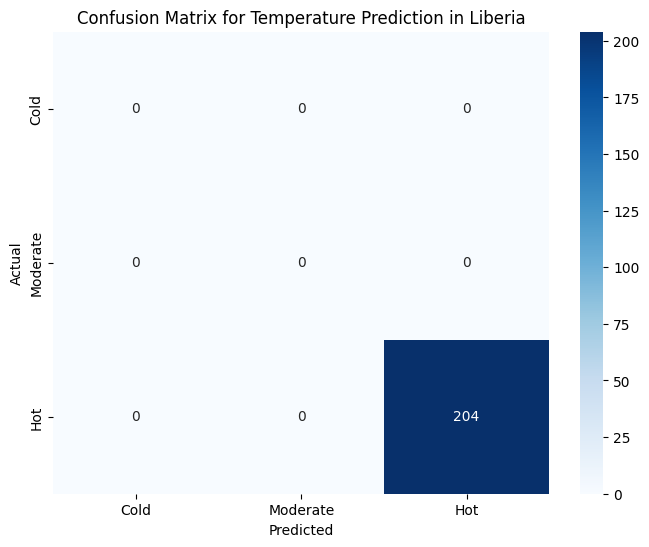

              precision    recall  f1-score   support

         Hot       1.00      1.00      1.00       204

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



In [ ]:
cold_threshold = 5.134167
hot_threshold = 18.507019

y_test_categories = []
for temp in y_test:
  if temp < cold_threshold:
    y_test_categories.append('Cold')
  elif temp < hot_threshold:
    y_test_categories.append('Moderate')
  else:
    y_test_categories.append('Hot')

y_pred_categories = []
for temp in y_pred:
  if temp < cold_threshold:
    y_pred_categories.append('Cold')
  elif temp < hot_threshold:
    y_pred_categories.append('Moderate')
  else:
    y_pred_categories.append('Hot')


cm = confusion_matrix(y_test_categories, y_pred_categories, labels=['Cold', 'Moderate', 'Hot'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=['Cold', 'Moderate', 'Hot'],yticklabels=['Cold', 'Moderate', 'Hot'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Temperature Prediction in Liberia')
plt.show()

print(classification_report(y_test_categories, y_pred_categories))

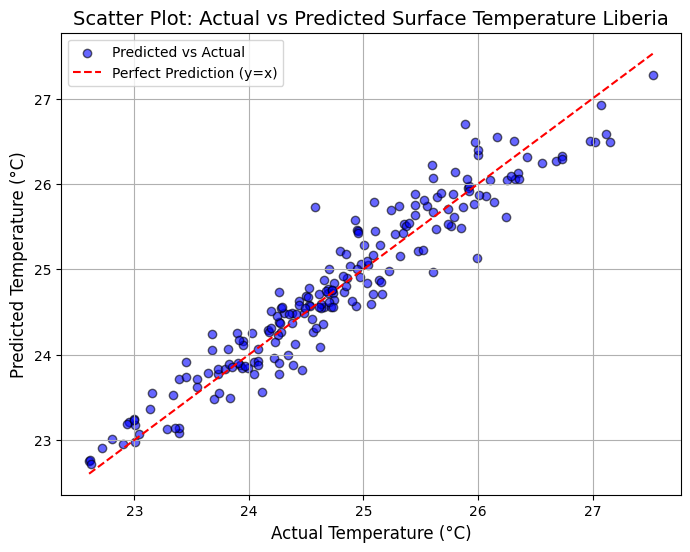

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolor='k', label='Predicted vs Actual')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction (y=x)')

plt.title('Scatter Plot: Actual vs Predicted Surface Temperature Liberia', fontsize=14)
plt.xlabel('Actual Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

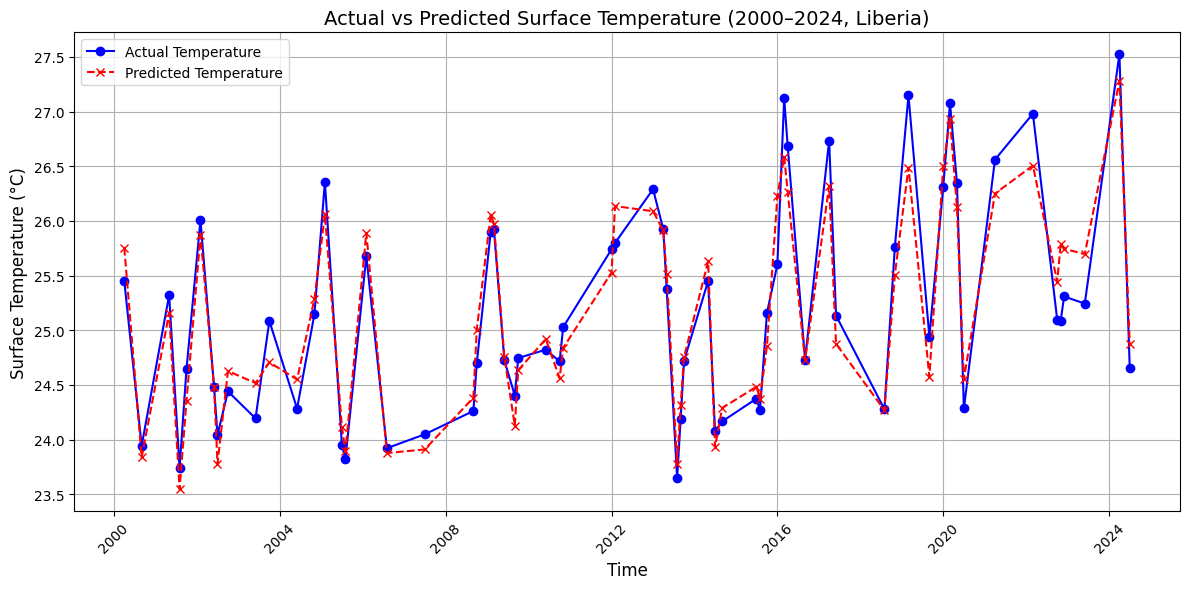

In [ ]:
data_visual_time = pd.DataFrame({
    'Year': X_test['year'],
    'Month': X_test['month'],
    'Actual Temperature': y_test.values,
    'Predicted Temperature': y_pred
})


data_visual_time['Time'] = pd.to_datetime(data_visual_time[['Year', 'Month']].assign(Day=1))
data_visual_time = data_visual_time.sort_values(by='Time')
data_visual_time_filtered = data_visual_time[(data_visual_time['Year'] >= 2000) & (data_visual_time['Year'] <= 2024)]

plt.figure(figsize=(12, 6))
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Actual Temperature'],label='Actual Temperature', color='blue', marker='o')
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Predicted Temperature'],label='Predicted Temperature', color='red', linestyle='--', marker='x')

plt.title('Actual vs Predicted Surface Temperature (2000–2024, Liberia)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Surface Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

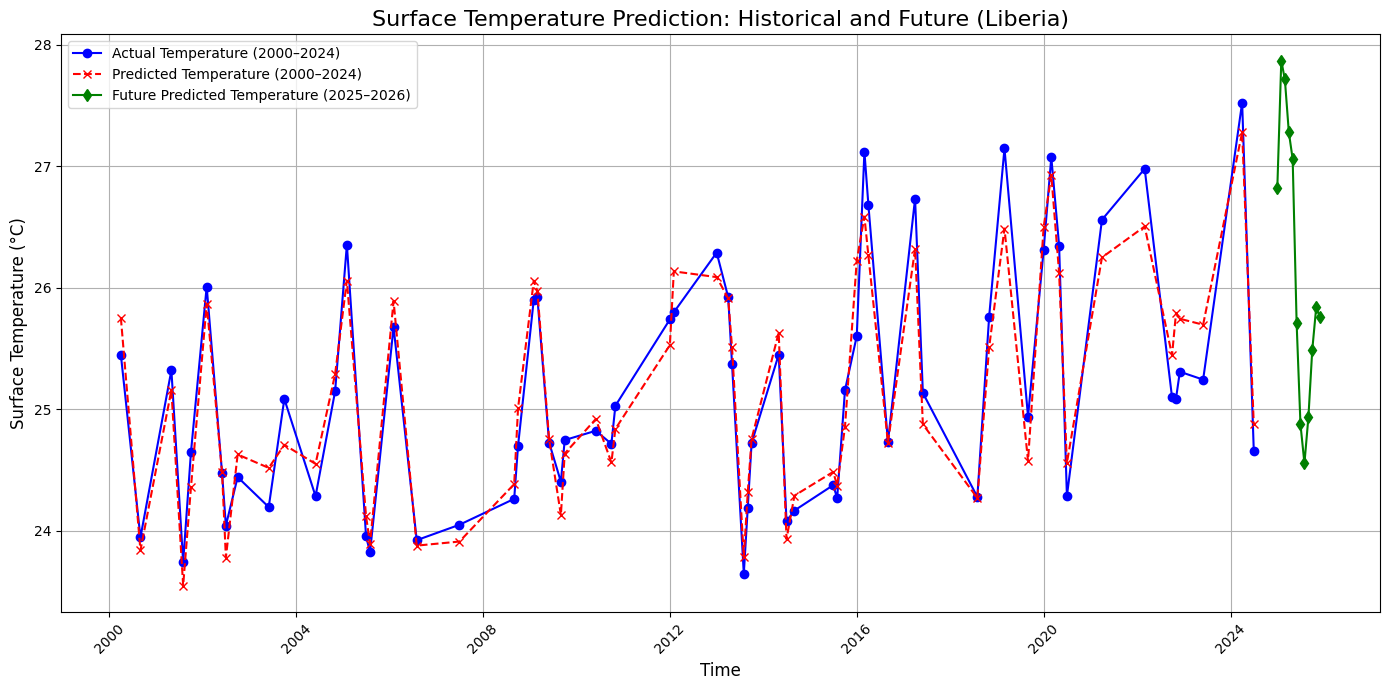

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(df_ts['Entity'])

future_years = pd.DataFrame({
    'year': np.repeat(range(2025, 2026), 12),
    'month': list(range(1, 13)),
    'average temperature year': [df_ts['Average_surface_temperature_year'].mean()] * 12,
    'Entity': [label_encoder.transform(['Liberia'])[0]] * 12
})

future_years_for_prediction = future_years[['year', 'month']]
future_years['Predicted Temperature'] = model.predict(future_years_for_prediction)
future_years['Time'] = pd.to_datetime(future_years[['year', 'month']].assign(Day=1))

plt.figure(figsize=(14, 7))
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Actual Temperature'],label='Actual Temperature (2000–2024)', color='blue', marker='o')
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Predicted Temperature'],label='Predicted Temperature (2000–2024)', color='red', linestyle='--', marker='x')
plt.plot(future_years['Time'], future_years['Predicted Temperature'],label='Future Predicted Temperature (2025–2026)', color='green', linestyle='-', marker='d')

plt.title('Surface Temperature Prediction: Historical and Future (Liberia)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Surface Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Germany

In [ ]:
df_ts = df_cleaned[df_cleaned['Entity'] == 'Germany']
print(df_ts.info())
df_ts.head()

<class 'pandas.core.frame.DataFrame'>
Index: 847 entries, 71122 to 72135
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Entity                             847 non-null    object        
 1   Code                               847 non-null    object        
 2   year                               847 non-null    int64         
 3   Day                                847 non-null    datetime64[ns]
 4   Average_surface_temperature_month  847 non-null    float64       
 5   Average_surface_temperature_year   847 non-null    float64       
 6   Temperature_anomaly                847 non-null    float64       
 7   Continent                          847 non-null    object        
 8   month                              847 non-null    int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), object(3)
memory usage: 62.9+ KB
None


Entity Code  year        Day  Average_surface_temperature_month  \
71122  Germany  DEU  1940 1940-03-15                           2.893441   
71123  Germany  DEU  1940 1940-04-15                           8.043474   
71124  Germany  DEU  1940 1940-05-15                          12.227314   
71125  Germany  DEU  1940 1940-06-15                          16.470922   
71126  Germany  DEU  1940 1940-07-15                          16.151615   

       Average_surface_temperature_year  Temperature_anomaly Continent  month  
71122                          6.586534            -1.868486    Europe      3  
71123                          6.586534            -1.036084    Europe      4  
71124                          6.586534            -0.953908    Europe      5  
71125                          6.586534             0.064753    Europe      6  
71126                          6.586534            -2.280451    Europe      7

In [ ]:
X = df_ts[['year', 'month']]
y = df_ts['Average_surface_temperature_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = XGBRegressor()
model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose = 10)

[0]	validation_0-rmse:4.40902	validation_1-rmse:4.54404
[10]	validation_0-rmse:0.95826	validation_1-rmse:1.22714
[20]	validation_0-rmse:0.81038	validation_1-rmse:1.24475
[30]	validation_0-rmse:0.70675	validation_1-rmse:1.25782
[40]	validation_0-rmse:0.63447	validation_1-rmse:1.27224
[50]	validation_0-rmse:0.56388	validation_1-rmse:1.28059
[60]	validation_0-rmse:0.50504	validation_1-rmse:1.29372
[70]	validation_0-rmse:0.45496	validation_1-rmse:1.30623
[80]	validation_0-rmse:0.41500	validation_1-rmse:1.31027
[90]	validation_0-rmse:0.37775	validation_1-rmse:1.31727
[99]	validation_0-rmse:0.34508	validation_1-rmse:1.32379


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Absolute Error (MAE): 1.1168352108454584
Mean Squared Error (MSE): 1.7524174563514205
Root Mean Squared Error (RMSE): 1.3237890528144658
Mean Absolute Percentage Error (MAPE): 1.3885419781288673


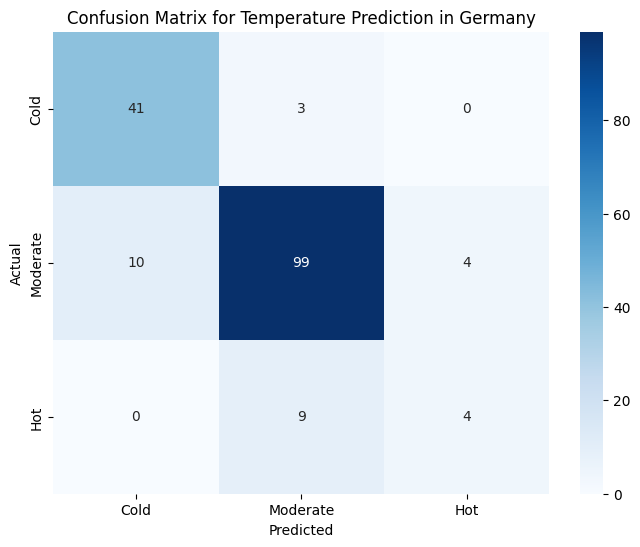

              precision    recall  f1-score   support

        Cold       0.80      0.93      0.86        44
         Hot       0.50      0.31      0.38        13
    Moderate       0.89      0.88      0.88       113

    accuracy                           0.85       170
   macro avg       0.73      0.71      0.71       170
weighted avg       0.84      0.85      0.84       170



In [ ]:
cold_threshold = 5.134167
hot_threshold = 18.507019

y_test_categories = []
for temp in y_test:
  if temp < cold_threshold:
    y_test_categories.append('Cold')
  elif temp < hot_threshold:
    y_test_categories.append('Moderate')
  else:
    y_test_categories.append('Hot')

y_pred_categories = []
for temp in y_pred:
  if temp < cold_threshold:
    y_pred_categories.append('Cold')
  elif temp < hot_threshold:
    y_pred_categories.append('Moderate')
  else:
    y_pred_categories.append('Hot')


cm = confusion_matrix(y_test_categories, y_pred_categories, labels=['Cold', 'Moderate', 'Hot'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=['Cold', 'Moderate', 'Hot'],yticklabels=['Cold', 'Moderate', 'Hot'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Temperature Prediction in Germany')
plt.show()

print(classification_report(y_test_categories, y_pred_categories))

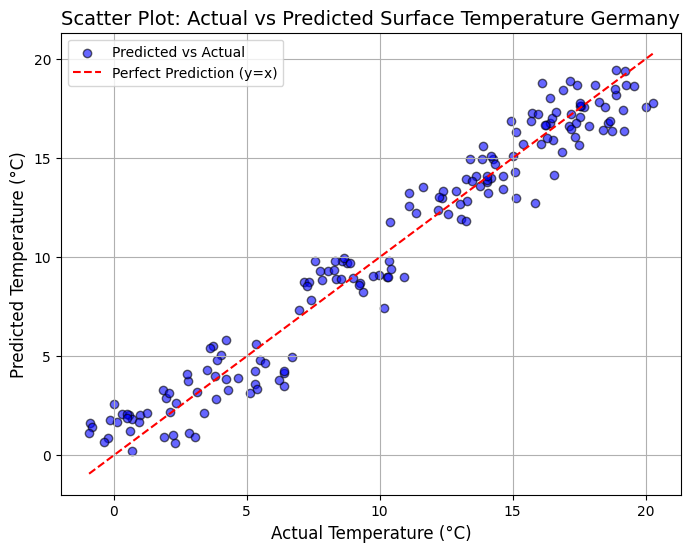

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolor='k', label='Predicted vs Actual')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction (y=x)')

plt.title('Scatter Plot: Actual vs Predicted Surface Temperature Germany', fontsize=14)
plt.xlabel('Actual Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

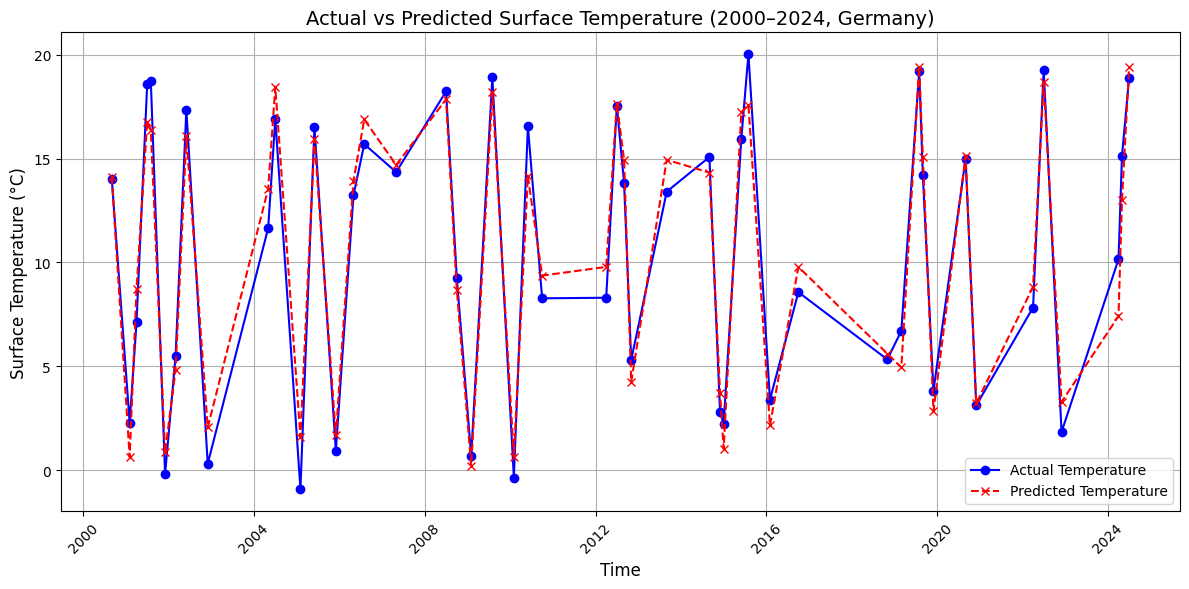

In [ ]:
data_visual_time = pd.DataFrame({
    'Year': X_test['year'],
    'Month': X_test['month'],
    'Actual Temperature': y_test.values,
    'Predicted Temperature': y_pred
})

data_visual_time['Time'] = pd.to_datetime(data_visual_time[['Year', 'Month']].assign(Day=1))
data_visual_time = data_visual_time.sort_values(by='Time')
data_visual_time_filtered = data_visual_time[(data_visual_time['Year'] >= 2000) & (data_visual_time['Year'] <= 2024)]

plt.figure(figsize=(12, 6))
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Actual Temperature'],label='Actual Temperature', color='blue', marker='o')
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Predicted Temperature'],label='Predicted Temperature', color='red', linestyle='--', marker='x')

plt.title('Actual vs Predicted Surface Temperature (2000–2024, Germany)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Surface Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

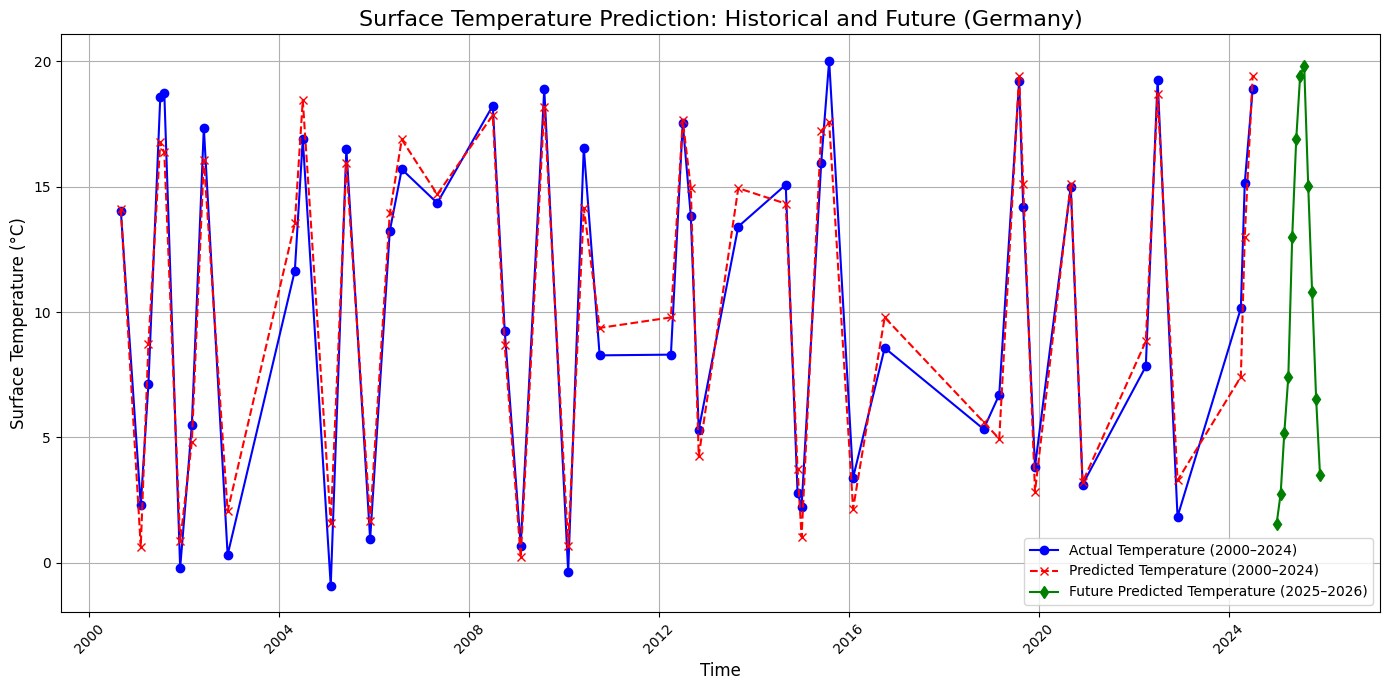

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(df_ts['Entity'])

future_years = pd.DataFrame({
    'year': np.repeat(range(2025, 2026), 12),
    'month': list(range(1, 13)),
    'average temperature year': [df_ts['Average_surface_temperature_year'].mean()] * 12,
    'Entity': [label_encoder.transform(['Germany'])[0]] * 12
})

future_years_for_prediction = future_years[['year', 'month']]
future_years['Predicted Temperature'] = model.predict(future_years_for_prediction)
future_years['Time'] = pd.to_datetime(future_years[['year', 'month']].assign(Day=1))

plt.figure(figsize=(14, 7))
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Actual Temperature'],label='Actual Temperature (2000–2024)', color='blue', marker='o')
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Predicted Temperature'],label='Predicted Temperature (2000–2024)', color='red', linestyle='--', marker='x')
plt.plot(future_years['Time'], future_years['Predicted Temperature'],label='Future Predicted Temperature (2025–2026)', color='green', linestyle='-', marker='d')

plt.title('Surface Temperature Prediction: Historical and Future (Germany)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Surface Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# United State

In [ ]:
df_ts = df_cleaned[df_cleaned['Entity'] == 'United States']
print(df_ts.info())
df_ts.head()

<class 'pandas.core.frame.DataFrame'>
Index: 977 entries, 186945 to 187959
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Entity                             977 non-null    object        
 1   Code                               977 non-null    object        
 2   year                               977 non-null    int64         
 3   Day                                977 non-null    datetime64[ns]
 4   Average_surface_temperature_month  977 non-null    float64       
 5   Average_surface_temperature_year   977 non-null    float64       
 6   Temperature_anomaly                977 non-null    float64       
 7   Continent                          977 non-null    object        
 8   month                              977 non-null    int32         
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1), object(3)
memory usage: 72.5+ KB
None


Entity Code  year        Day  \
186945  United States  USA  1940 1940-02-15   
186946  United States  USA  1940 1940-03-15   
186947  United States  USA  1940 1940-04-15   
186948  United States  USA  1940 1940-05-15   
186949  United States  USA  1940 1940-06-15   

        Average_surface_temperature_month  Average_surface_temperature_year  \
186945                          -3.639929                          8.045168   
186946                           0.422743                          8.045168   
186947                           6.756010                          8.045168   
186948                          13.282525                          8.045168   
186949                          18.751434                          8.045168   

        Temperature_anomaly Continent  month  
186945            -2.890490   America      2  
186946            -2.953063   America      3  
186947            -2.042028   America      4  
186948            -1.217835   America      5  
186949            -0.814058   America      6

In [ ]:
X = df_ts[['year', 'month']]
y = df_ts['Average_surface_temperature_month']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],verbose = 10)

[0]	validation_0-rmse:6.35805	validation_1-rmse:6.15418
[10]	validation_0-rmse:0.68625	validation_1-rmse:0.82106
[20]	validation_0-rmse:0.51745	validation_1-rmse:0.78760
[30]	validation_0-rmse:0.45560	validation_1-rmse:0.79523
[40]	validation_0-rmse:0.41726	validation_1-rmse:0.80223
[50]	validation_0-rmse:0.36863	validation_1-rmse:0.79531
[60]	validation_0-rmse:0.33408	validation_1-rmse:0.79206
[70]	validation_0-rmse:0.29603	validation_1-rmse:0.79945
[80]	validation_0-rmse:0.26227	validation_1-rmse:0.80147
[90]	validation_0-rmse:0.24254	validation_1-rmse:0.80560
[99]	validation_0-rmse:0.22211	validation_1-rmse:0.80566


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Absolute Error (MAE): 0.6341678788728677
Mean Squared Error (MSE): 0.6490904350897062
Root Mean Squared Error (RMSE): 0.8056614891439867
Mean Absolute Percentage Error (MAPE): 2.774762559087716


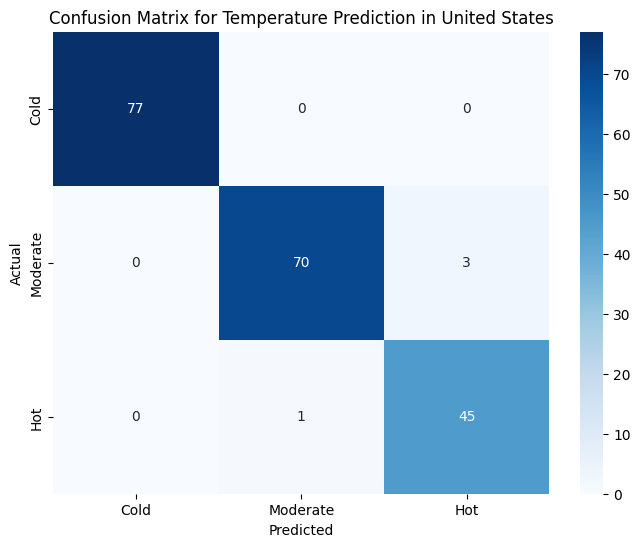

              precision    recall  f1-score   support

        Cold       1.00      1.00      1.00        77
         Hot       0.94      0.98      0.96        46
    Moderate       0.99      0.96      0.97        73

    accuracy                           0.98       196
   macro avg       0.97      0.98      0.98       196
weighted avg       0.98      0.98      0.98       196



In [ ]:
cold_threshold = 5.134167
hot_threshold = 18.507019

y_test_categories = []
for temp in y_test:
  if temp < cold_threshold:
    y_test_categories.append('Cold')
  elif temp < hot_threshold:
    y_test_categories.append('Moderate')
  else:
    y_test_categories.append('Hot')

y_pred_categories = []
for temp in y_pred:
  if temp < cold_threshold:
    y_pred_categories.append('Cold')
  elif temp < hot_threshold:
    y_pred_categories.append('Moderate')
  else:
    y_pred_categories.append('Hot')


cm = confusion_matrix(y_test_categories, y_pred_categories, labels=['Cold', 'Moderate', 'Hot'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=['Cold', 'Moderate', 'Hot'],yticklabels=['Cold', 'Moderate', 'Hot'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Temperature Prediction in United States')
plt.show()

print(classification_report(y_test_categories, y_pred_categories))

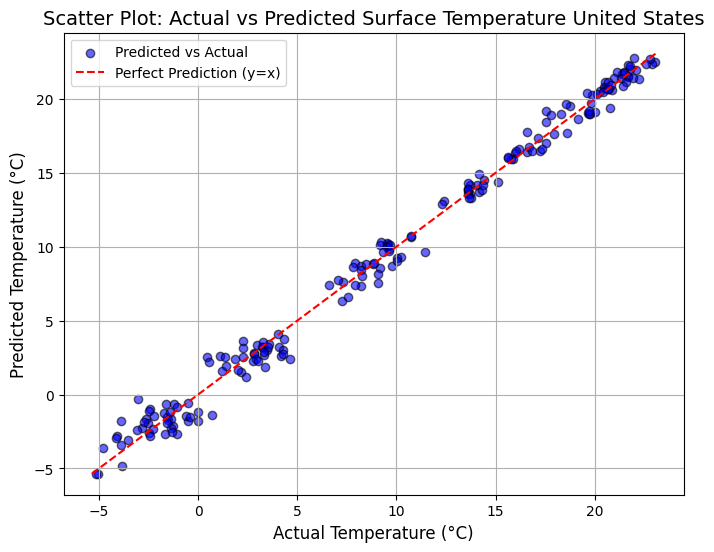

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolor='k', label='Predicted vs Actual')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction (y=x)')

plt.title('Scatter Plot: Actual vs Predicted Surface Temperature United States', fontsize=14)
plt.xlabel('Actual Temperature (°C)', fontsize=12)
plt.ylabel('Predicted Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

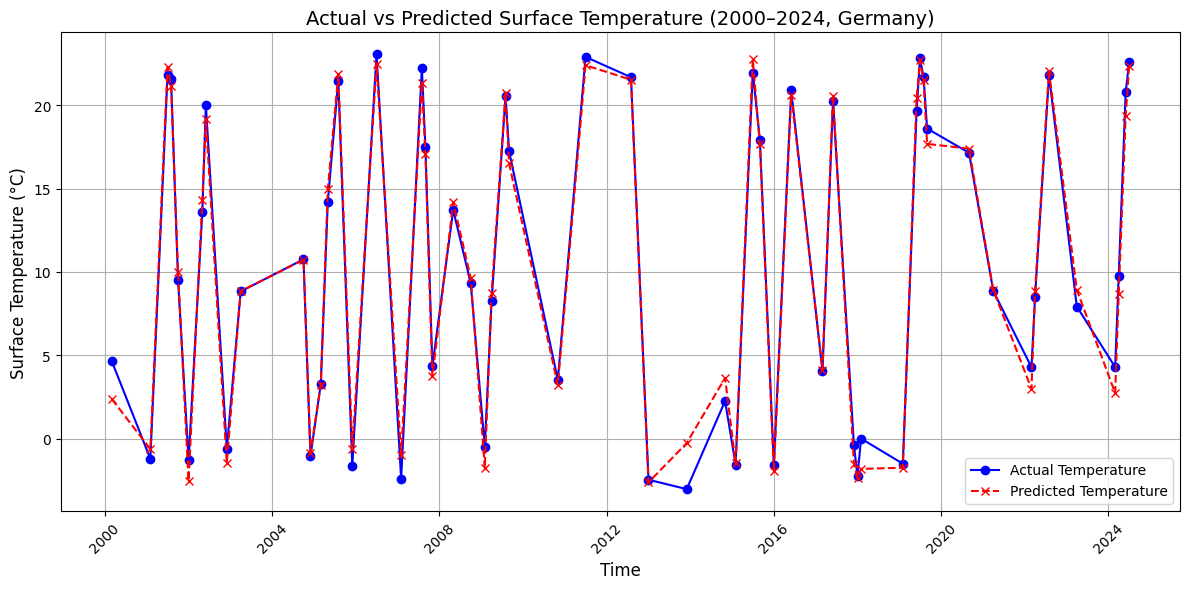

In [ ]:
data_visual_time = pd.DataFrame({
    'Year': X_test['year'],
    'Month': X_test['month'],
    'Actual Temperature': y_test.values,
    'Predicted Temperature': y_pred
})

data_visual_time['Time'] = pd.to_datetime(data_visual_time[['Year', 'Month']].assign(Day=1))
data_visual_time = data_visual_time.sort_values(by='Time')
data_visual_time_filtered = data_visual_time[(data_visual_time['Year'] >= 2000) & (data_visual_time['Year'] <= 2024)]

plt.figure(figsize=(12, 6))
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Actual Temperature'],label='Actual Temperature', color='blue', marker='o')
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Predicted Temperature'],label='Predicted Temperature', color='red', linestyle='--', marker='x')

plt.title('Actual vs Predicted Surface Temperature (2000–2024, Germany)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Surface Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

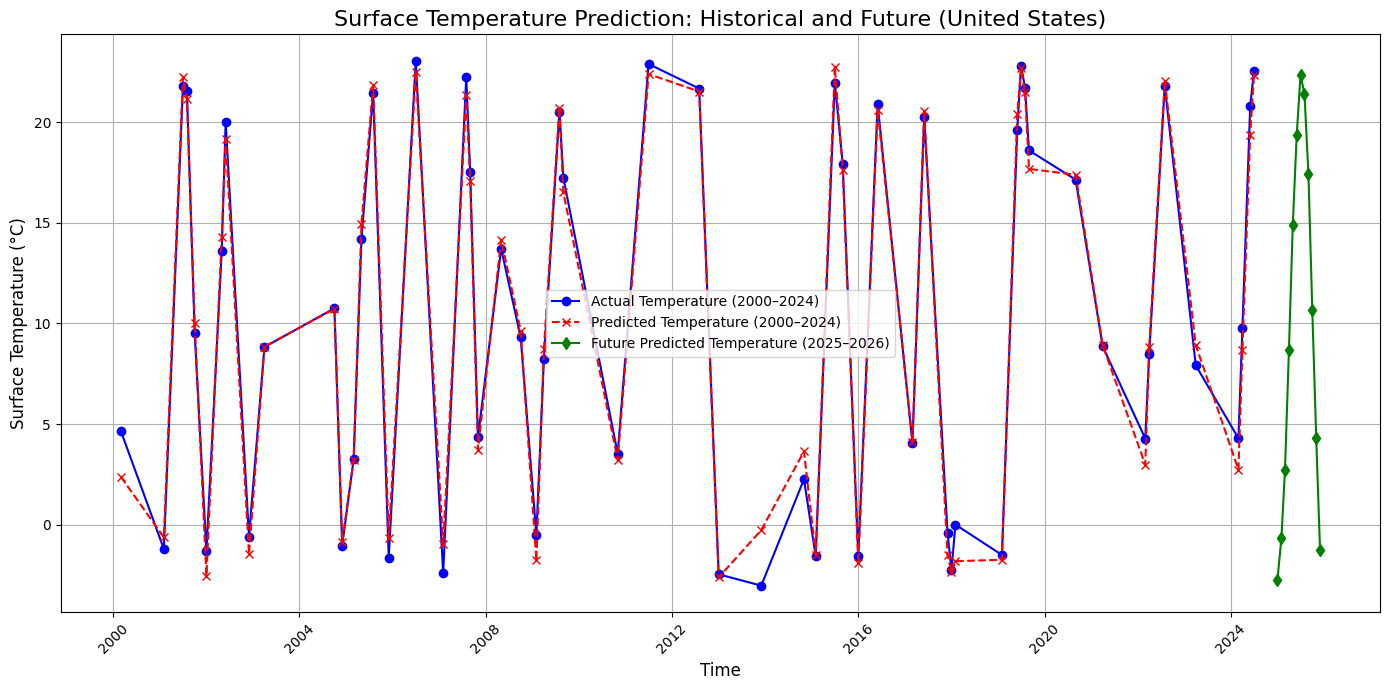

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(df_ts['Entity'])

future_years = pd.DataFrame({
    'year': np.repeat(range(2025, 2026), 12),
    'month': list(range(1, 13)),
    'average temperature year': [df_ts['Average_surface_temperature_year'].mean()] * 12,
    'Entity': [label_encoder.transform(['United States'])[0]] * 12
})

future_years_for_prediction = future_years[['year', 'month']]
future_years['Predicted Temperature'] = model.predict(future_years_for_prediction)
future_years['Time'] = pd.to_datetime(future_years[['year', 'month']].assign(Day=1))

plt.figure(figsize=(14, 7))
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Actual Temperature'],label='Actual Temperature (2000–2024)', color='blue', marker='o')
plt.plot(data_visual_time_filtered['Time'], data_visual_time_filtered['Predicted Temperature'],label='Predicted Temperature (2000–2024)', color='red', linestyle='--', marker='x')
plt.plot(future_years['Time'], future_years['Predicted Temperature'],label='Future Predicted Temperature (2025–2026)', color='green', linestyle='-', marker='d')

plt.title('Surface Temperature Prediction: Historical and Future (United States)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Surface Temperature (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()